In [1]:
'''
Multiple (8) base and grid searched classification models were run on
1.	all the features provided
2.	top 10 selected features
3.	PCA with 8 components having 80% cumulative variance

Model interpretability using Shap, lime and PDP (Partial Dependence Plot )
'''

'\nMultiple (8) base and grid searched classification models were run on\n1.\tall the features provided\n2.\ttop 10 selected features\n3.\tPCA with 8 components having 80% cumulative variance\n'

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', 500)   # to display 500 columns
pd.set_option('display.max_rows', 500)      # to display 500 rows


from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier              
                
from six import StringIO
from sklearn.tree import export_graphviz

plt.rc("figure", figsize=(9, 7))

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Defining functions for various tasks - EDA, cleaning, feature seelction, PCA,
### modelling, Gridsearch, model evaluation

In [3]:
def load_file(file):
    df = pd.read_csv(file, delimiter=",", header=None )
    print(df.shape)
        
    return df

In [4]:
def Perform_EDA(df, target):
        
        print('Printing the column names: ')
        print('------------')
        print(df.columns)
        print(' ')
        
        print('Renaming the columns: ')
        print('------------')
        
        df.columns = ['age','sex','chest_pain','resting_bp','chol','fbs','restecg',
                      'thalach','exang','oldpeak','slope','ca','thal','heart_disease']
    
        print(df.columns)
        print(' ')
        
        print('Size of the DataFrame: ')
        print('------------')
        print('df.shape: ')
        print(df.shape)
        print(' ')
        
        print('Data types: ')
        print('------------')
        print('df.info: ')
        print(df.info())
        print(' ')
        
        print('Printing value counts for each variable: ')
        print('------------')
        print(df.nunique())
        print(' ')
        
        
        #print('Printing outcomes of target column: ')
        #print('------------')
        #print(df[target].value_counts())
        #print(' ')
        
        # Checking for Nulls
        print('Checking for Nulls')
        print('--------------')
        print(df.isnull().sum())
        print('--------------')
        print(' ')
    
        # Identifying outliers
        print('Data Statistics to identify skewness and outliers etc: ')
        print('------------')
        print('df.describe')
        print(df.describe(include='all')) 
        print(' ')
        
        return df

In [5]:
def targetVariableAdjustments(df, target):
    
    # Making the target variable binary, 0 when it was 0 and 1 when it was either 1,2,3,4
    df[target] = df[target].replace([1,2,3, 4],[1,1,1,1])
    
    return df

In [6]:
def plotting(df, target):
    # Box plots and Bar plots
    
    #binary_features = ['sex', 'fbs', 'exang'] # ,target
    categorical_features = ['sex', 'fbs', 'exang', 'chest_pain', 'restecg', 
                            'slope', 'ca', 'thal']
    continuous_features = ['age', 'resting_bp', 'chol',  'oldpeak', 'thalach']
    
    plt.figure(figsize=(15, 15))

    # Categorical Features plotting
    
     #df[categorical_features].plot(kind='bar', subplots=True, layout=(2,8),
      #      sharex=False,sharey=False, figsize=(20, 10) ); 
    
    for i, column in enumerate(categorical_features, 1):
        plt.subplot(2, 4, i)


        df[df[target] == 0][column].hist(bins=35, color='green', label='Heart_Disease = NO', alpha=0.5)
        df[df[target] == 1][column].hist(bins=35, color='red', label='Heart_Disease = YES', alpha=0.5)
        plt.legend()
        plt.xlabel(column)
    
    # Continuous Features plotting
    
    df[continuous_features].plot(kind='box', subplots=True, layout=(2,7),
    sharex=False,sharey=False, figsize=(20, 10) ); 
    
    return categorical_features, continuous_features


In [7]:
def DataCleaning(df):
    
        '''
        Steps:
        After close analysis of the features (esp Object type)

        1. TypeCasting object to int or float and removing any non-numeric characters
        
        2. TypeCasting float into int64 (except 'oldpeak' all the other features 
                looks int, so typecasting to save memory)
                
        3. Deleting Nulls (Not imputing as number of nulls are very small)

        4. drop duplicates, if any
        
        5. Removing outliers
            chol, oldpeak and thalac seems to have outliers. 
            limiting to within Q1 - 1.5IQR and Q3 + 1.5IQR range
        '''

     # 1. TypeCasting object to int or float
         # removes any ascii etc chars
        df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
        df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

        
     # 2  Tpecasting float to int #except 'oldpeak' 
        df[['sex', 'fbs', 'exang', 'chest_pain', 'restecg','slope', 'age',
            'resting_bp', 'chol', 'thalach']] = df[['sex', 'fbs', 'exang', 
                                                  'chest_pain', 'restecg','slope',
                                                  'age','resting_bp', 'chol', 
                                                  'thalach']].astype('int64')
       
                        
    # 3. Dropping Nans (or impute with mean, mode etc)
        df.dropna(inplace=True)
        
    # 4. Dropping duplicates, if any
        df.drop_duplicates(inplace = True)
    
    # 5. Removing outliers
    # chol, oldpeak and thalac seems to have outliers

        Q1 = np.percentile(df, 25, interpolation = 'midpoint')
        Q3 = np.percentile(df, 75, interpolation = 'midpoint') 
        
        IQR = Q3-Q1 # Interquartile Range
        
        lower_limits = Q1 - (IQR * 1.5)
        upper_limits = Q3 + (IQR * 1.5)
        
        df = df[~((df >= upper_limits) & (df <= lower_limits))]#.index.tolist()  
        
      # Checking for Nulls
        print('Checking for Nulls')
        print('--------------')
        print(df.isnull().sum())
        print('--------------')
        print(' ')
        
        
     # Checking for Outliers again
        #print('Checking for outliers')
        #print('--------------')
        #print(df.describe(include='all')) 
        #print('--------------')
        #print(' ')

        print('info: ')
        print(df.info())
        print('--------------')
        print(' ')

        print('shape: ')
        print(df.shape)

        return df

In [8]:
def DataVisualizations(df, target, categorical_features, continuous_features):
    
    # Plot distributions
       # 1. numerical_features = histogram
       # 2. pair plots
    
    # 1. Histograms
        
    plt.figure(figsize=(15, 15))
    
    for i, column in enumerate(continuous_features, 1):
        plt.subplot(2, 3, i)
        df[df[target] == 0][column].hist(bins=35, color='green', label='Heart_Disease->No', alpha=0.6)
        df[df[target] == 1][column].hist(bins=35, color='red', label='Heart_Disease->Yes', alpha=0.6)
        plt.legend()
        plt.xlabel(column)

    
    # 2. Visualizing the relationship between features (Hue for Outcome)

    sns.pairplot(data=df, vars=list(df.select_dtypes([np.number]).columns),
                       hue=target, height=3)
    plt.show()
    

In [9]:
def TrainTestSplit_Standardization(df, target, test_size):

        # Features 
        y = df[target]
        X = df[df.columns.difference([target])] # All columns excpet the target

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            shuffle=True, stratify=y) 
        print(X_train.shape)
        print(y_train.shape)
        print(X_test.shape)
        print(y_test.shape)
        
        # Preserving for future use (bias evaluation)
        
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = X_train, X_test, y_train, y_test

        # Standardize the data

        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        return X_train, X_test, y_train, y_test, X_train_orig, X_test_orig, y_train_orig, y_test_orig

In [10]:
def featureSelection(df, target, X_train, y_train):
    
    # Using the following measures to identify best features
    
    # 1. Correlation
    # 2. SelectKBest 
    # 3. VIF - to identify multicolinearity
    
    
    # 1. Correlation

        print('Plotting correlation')
        print('------------')
        
        corr = df.corr()

        fig, ax = plt.subplots(figsize=(20,12))
        matrix = np.triu(corr)
        ax = sns.heatmap(corr, annot = True, mask=matrix, center= 0, cmap="BuPu" ,fmt='.1g'); #cmap= 'coolwarm',    

        plt.show()
          
        
     # 2. selecting best features
        #from sklearn.feature_selection import SelectKBest, chi2, f_classif
        
        #X = df[df.columns.difference([target])] # All columns excpet the target
        
        print(' ')
        print('Plotting K-best features')
        print('------------')
        
        selector = SelectKBest(score_func=f_classif, k='all')# chi2  f_classif
        fit = selector.fit(X_train, y_train)
        scores = -np.log10(fit.pvalues_)
        scores /= scores.max()
        
        #X_indices = np.arange(X_train.shape[-1])
        
        #plt.bar(X_indices - .45, scores, width=.2,
         #       label=r'Score ($-Log(p_{value})$)')
    
        df_pvalues = pd.DataFrame(fit.pvalues_)
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_train.columns)
        
        # concatenate dataframes
        feature_scores = pd.concat([df_columns, df_scores, df_pvalues],axis=1)
        feature_scores.columns = ['Feature_Name','Score', 'p-values']  # name output columns
        print(feature_scores.nlargest(12,'Score'))
        
            
    # 3. VIF
        print(' ')
        print('Variation Inflation Factor')
        print('------------')
        
        #from statsmodels.stats.outliers_influence import variance_inflation_factor
              
        vif = pd.DataFrame()
        vif["Features"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        print(vif.sort_values(by='VIF', ascending=False)) 
        

In [11]:
# Feature selection based on corealtion and SelectK features and VIF 
# (we select the variables with high VIF as collinear variables)

def selectedFeatures(X_train, X_test):
 # dropping  fbs, age, sex, chol, resting_bp, restecg
    
    X_train = X_train.drop(columns = ['fbs', 'chol', 'resting_bp'], axis = 1) #,'restecg'
    X_test = X_test.drop(columns = ['fbs', 'chol', 'resting_bp'], axis = 1)#, 'restecg'
    
    print('X_train: ', X_train.shape)
    print('X_test: ',X_test.shape)
    
    return X_train, X_test

In [12]:
def PCA(X_train, X_test):

    from sklearn.decomposition import PCA

    pca = PCA(n_components=8)  # 8 components have 80% variance

    X_train_pca = pca.fit_transform(X_train) # PCA fit-tranform on train data
    X_test_pca = pca.transform(X_test)       # PCA tranform on test data
    
    # Converting into DataFrame
    PCA_col_dict = {'PCA'+str(i+1): pca.components_[i]
                for i in range(len(pca.components_))}
    
    df_pca = pd.DataFrame(PCA_col_dict, index=X_train.columns) 
    
    X_train_pca = pd.DataFrame(X_train_pca, columns=PCA_col_dict) 
    #print(X_train_pca.shape)

    X_test_pca = pd.DataFrame(X_test_pca, columns=PCA_col_dict) 
    #print(X_test_pca.shape)
    
    explained_variance = pca.explained_variance_ratio_
    explained_variance.cumsum()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    x_values = list(range(1, pca.n_components_+1))
    ax.plot(x_values, explained_variance, lw=2)
    ax.scatter(x_values, explained_variance, s=120)
    ax.plot(x_values, np.cumsum(explained_variance), lw=2)
    ax.scatter(x_values, np.cumsum(explained_variance), s=120)

    ax.set_title('Explained variance pct\n', fontsize=20)
    ax.set_xlabel('Principal Component', fontsize=16)
    ax.set_ylabel('Variance Explained (%)', fontsize=16)
    plt.show()

    return df_pca, X_train_pca, X_test_pca

In [13]:
def baseModelFitting(classifiers, n_splits, X_train, X_test, y_train, y_test):
        
        fitted_classifiers = {} #[]
        
        for name, classifier in classifiers:
            
            classifier.fit(X_train, y_train)

            kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

            train_score = classifier.score(X_train, y_train)
            trainCV_score = cross_val_score(classifier, X_train, y_train, cv = kf).mean()
            test_score = classifier.score(X_test, y_test)

            print('Classifier: ', classifier)
            print(' ')
            
            # Classification report
            print('Classification report')
            predictions = classifier.predict(X_test)
            print(classification_report(y_test, predictions))
            
            print(' ')
            print('Confusion Matrix')
            
            labels=[0, 1]
            confusion_mat = confusion_matrix(y_test, predictions, labels=labels)
            

            confusion_mat = pd.DataFrame(confusion_mat,
             columns=['Predicted_No', 'Predicted_Yes'],
             index=  ['True_No', 'True_Yes'])
            
            print(confusion_mat)
            
            #print("Score(Train): ", train_score)
            #print("Cross Val Score (Train): ", trainCV_score) 
            #print("Score (Test): ", test_score)
            print('-------------------------------------------')
            
            #fitted_classifiers.append(classifier)
            fitted_classifiers[name] = classifier

        return fitted_classifiers
    

In [14]:
def gridSearchModelFitting(classifiers, grid_search_params, n_splits, X_train, X_test, y_train, y_test):
        
        # Storing the best estimator from each classifier
        best_gs_classifiers = {}
        
        for classifier, grid_search_param in zip(base_classifiers, grid_search_params):
            
            # Note classifier[0] is name and classifier[1] is the model
            
            kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

            gridsearchedClassifier = GridSearchCV(estimator=classifier[1],
                                             param_grid=grid_search_param,
                                             cv=kf,
                                             scoring='accuracy',  
                                             n_jobs=-1,                                  
                                             verbose=0,
                                             return_train_score=True,
                                             refit=True
                                            )
        
            gridsearchedClassifier.fit(X_train, y_train)
        
            gs_cv_score = cross_val_score(gridsearchedClassifier, X_train, y_train, cv=kf).mean()
            gs_best_test_score = gridsearchedClassifier.best_estimator_.score(X_test, y_test)

            print('Classifier: ', classifier[0])
            print("model cross val score: %.3f" % gs_cv_score)
            print("model best score: %.3f" % gridsearchedClassifier.best_score_)
            print("model test score: %.3f" % gs_best_test_score)
            print("----------------------")
        
            best_gs_classifiers[classifier[0]] = {
                     'Best Estimator': gridsearchedClassifier.best_estimator_,
                     'Best Score': gridsearchedClassifier.best_score_,
                     'Best test score' : gs_best_test_score,
                     'Best params': gridsearchedClassifier.best_params_
                    }   
        
        return best_gs_classifiers
        

### Running the functions

#### Loading file

In [15]:
file_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
#file_path = "processed.cleveland.data" 

# The file .data is comma delimited and doesnt have a header
heartDF = load_file(file_path) #pd.read_csv(file_path, delimiter=",", header=None)

(303, 14)


In [16]:
heartDF.head()

0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0

In [17]:
target = "heart_disease"
heartDF = Perform_EDA(heartDF, target)

Printing the column names: 
------------
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
 
Renaming the columns: 
------------
Index(['age', 'sex', 'chest_pain', 'resting_bp', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heart_disease'],
      dtype='object')
 
Size of the DataFrame: 
------------
df.shape: 
(303, 14)
 
Data types: 
------------
df.info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age              303 non-null float64
sex              303 non-null float64
chest_pain       303 non-null float64
resting_bp       303 non-null float64
chol             303 non-null float64
fbs              303 non-null float64
restecg          303 non-null float64
thalach          303 non-null float64
exang            303 non-null float64
oldpeak          303 non-null float64
slope            303 non-null float64
ca               303 non-null object
thal         

In [18]:
# Since target have 5 values, so whenitevr its 0 we assign 0 which means no Heart disease,
# for values of 1,2,3,4 we assign 1, which means the patinet has heart disease.

heartDF = targetVariableAdjustments(heartDF, target)

In [19]:
print(heartDF.heart_disease.value_counts())
print('--------------------------------')
print('Baseline Accuracy')
print(heartDF.heart_disease.value_counts(normalize=True))
print('--------------------------------')
heartDF.head(2)

0    164
1    139
Name: heart_disease, dtype: int64
--------------------------------
Baseline Accuracy
0    0.541254
1    0.458746
Name: heart_disease, dtype: float64
--------------------------------


age  sex  chest_pain  resting_bp   chol  fbs  restecg  thalach  exang  \
0  63.0  1.0         1.0       145.0  233.0  1.0      2.0    150.0    0.0   
1  67.0  1.0         4.0       160.0  286.0  0.0      2.0    108.0    1.0   

   oldpeak  slope   ca thal  heart_disease  
0      2.3    3.0  0.0  6.0              0  
1      1.5    2.0  3.0  3.0              1

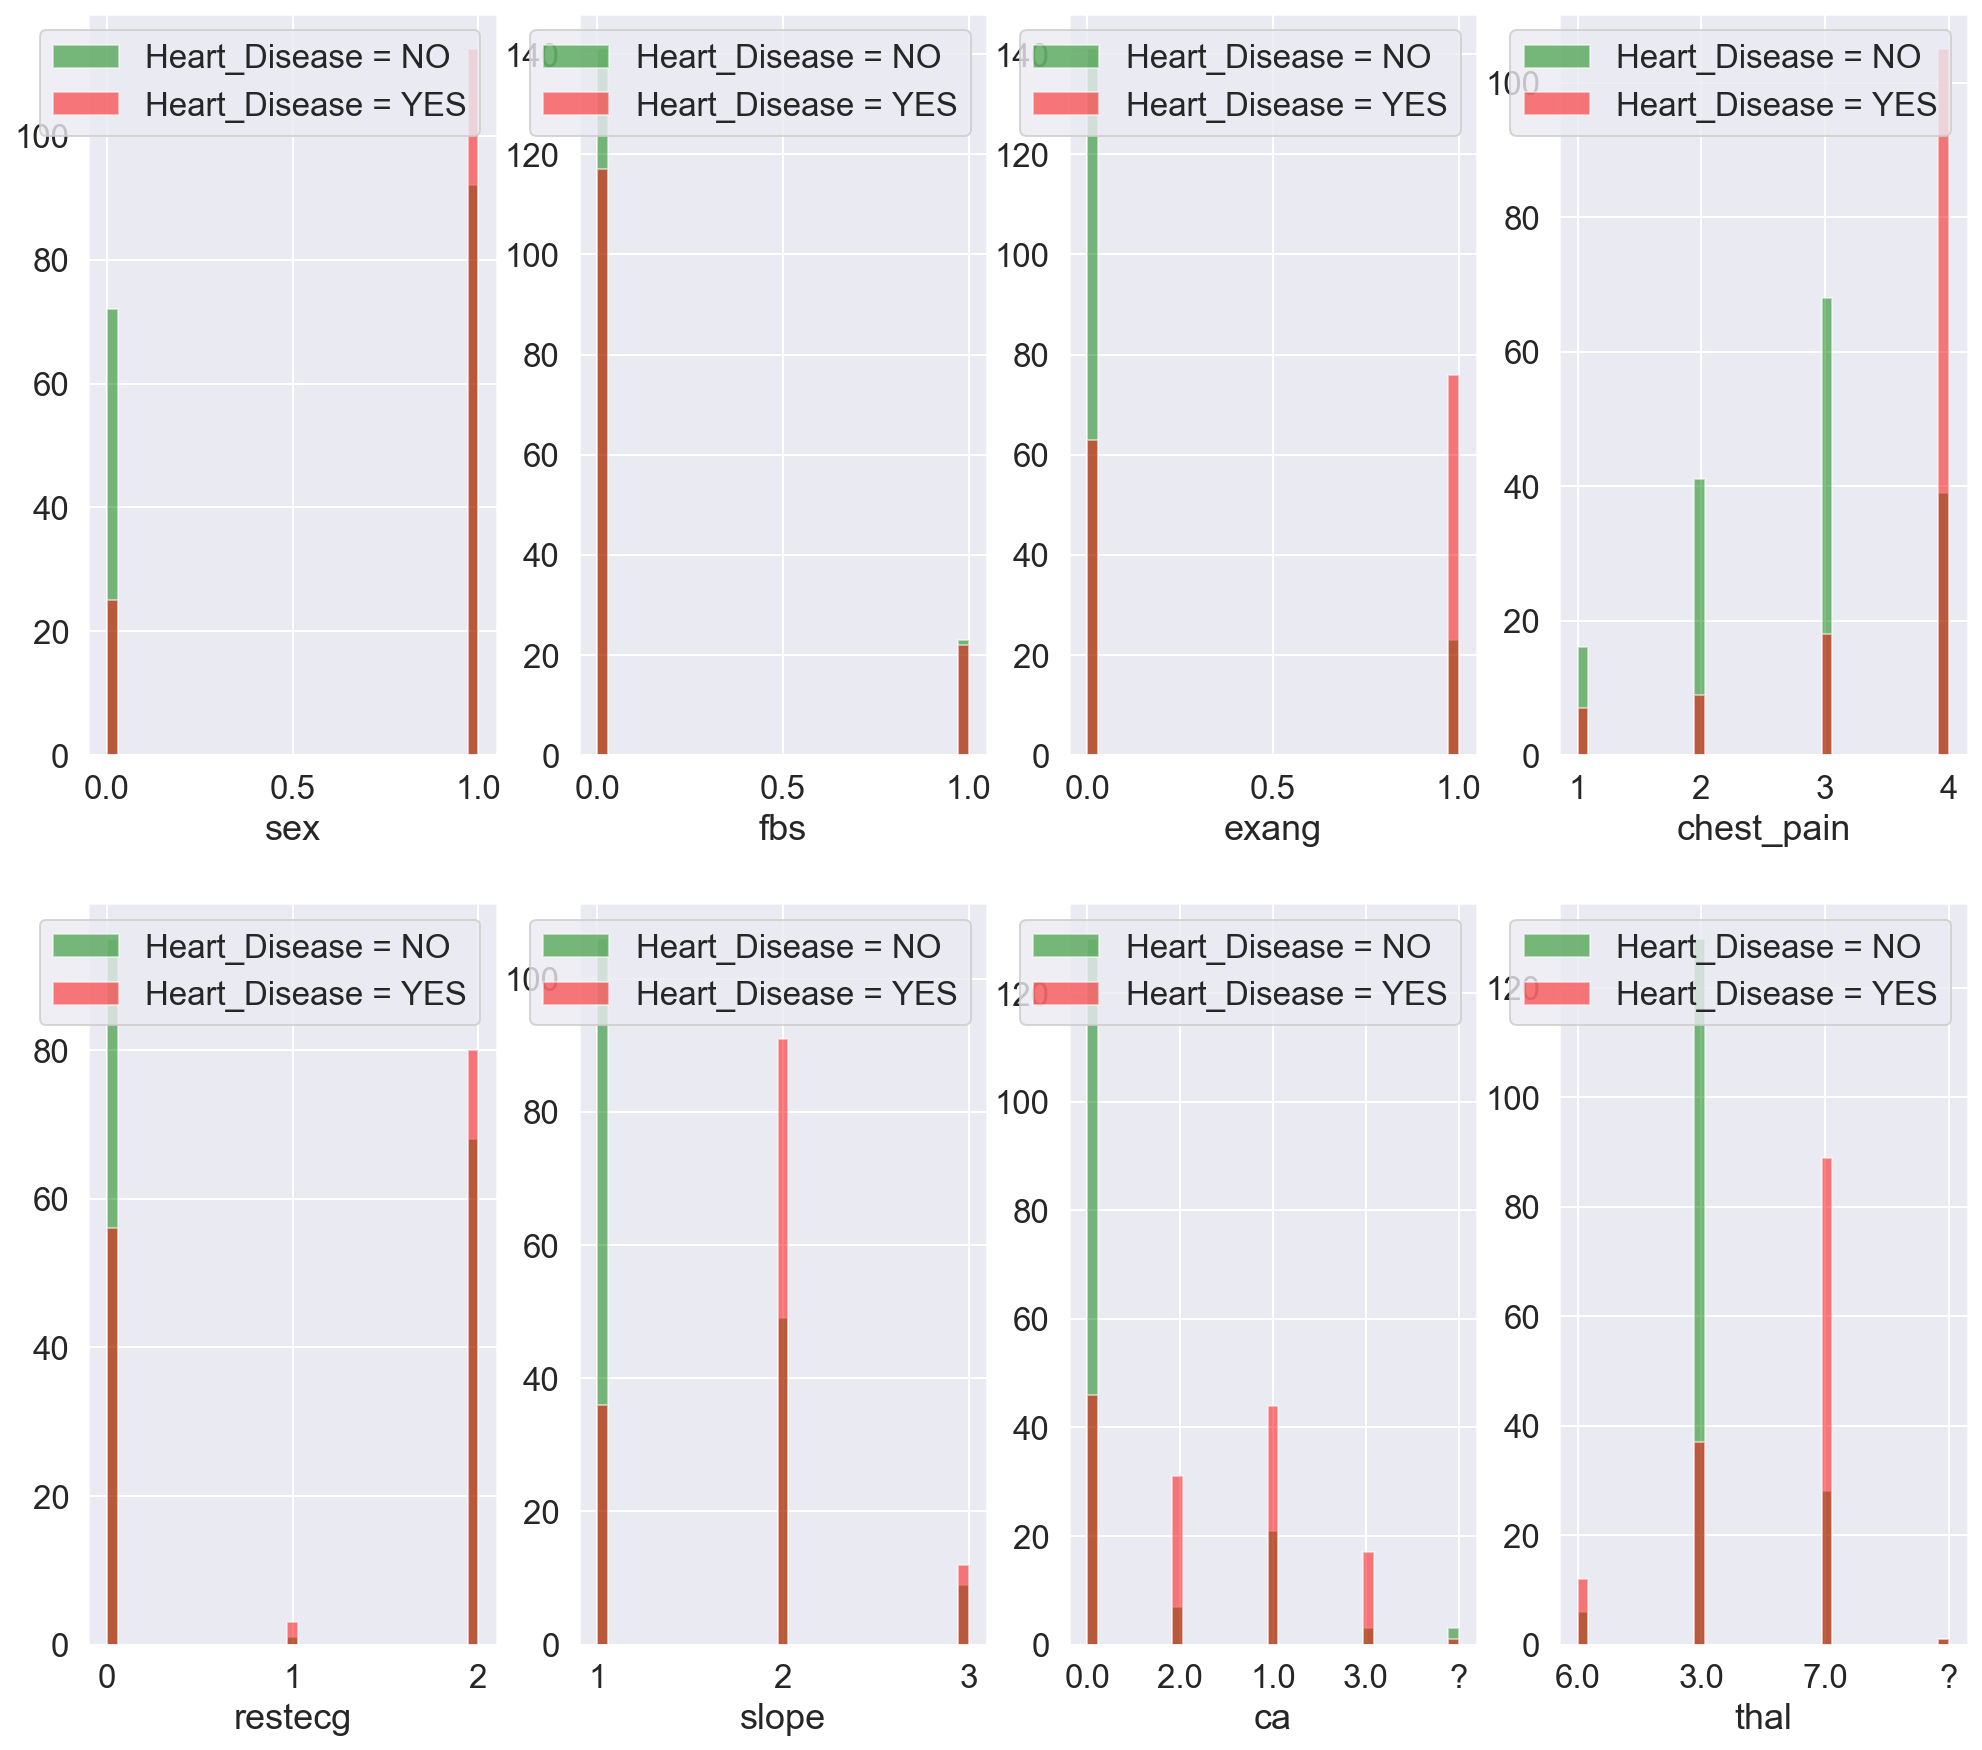

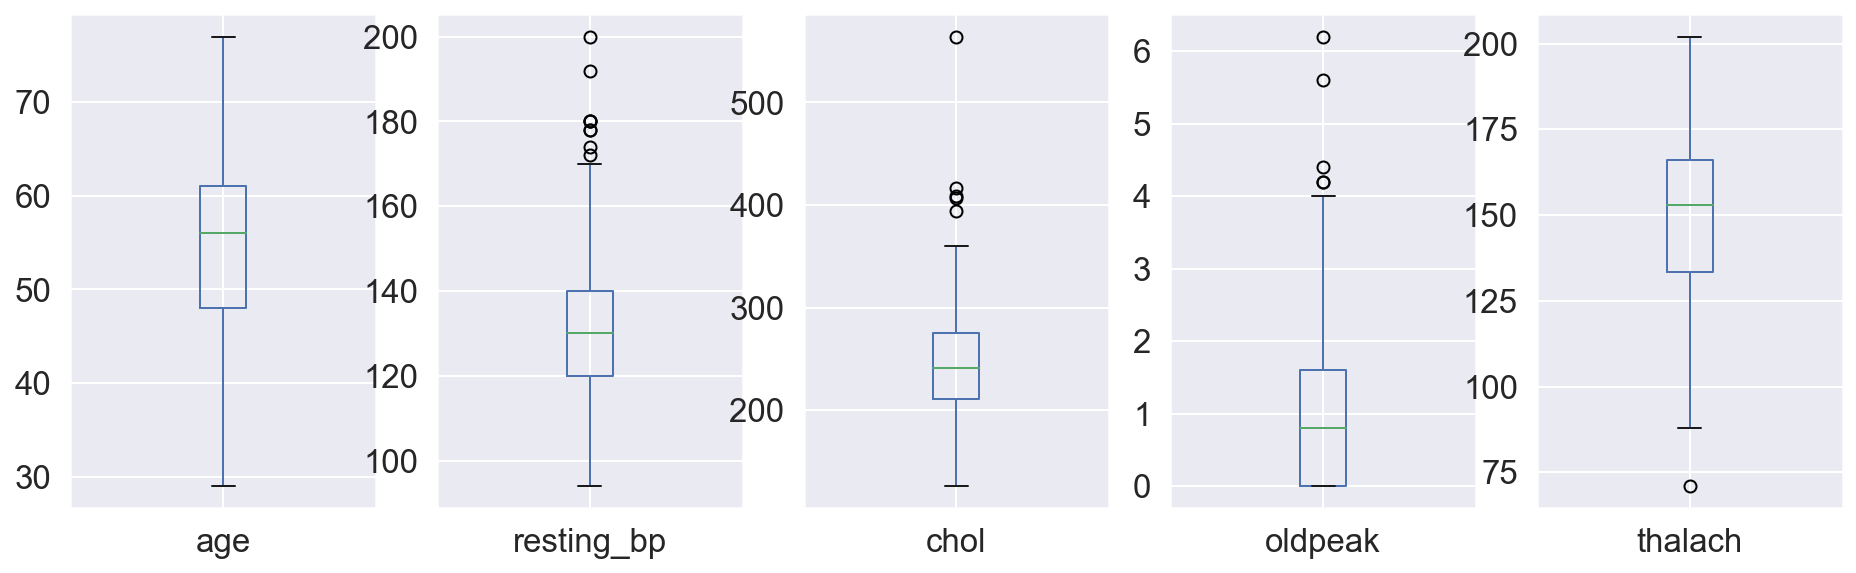

In [20]:
# Box plot and bar chart plotting to understand the features and identify any outliers

categorical_features, continuous_features = plotting(heartDF, target)

In [21]:
heartDF = DataCleaning(heartDF)
heartDF.head(2)

Checking for Nulls
--------------
age              0
sex              0
chest_pain       0
resting_bp       0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               0
thal             0
heart_disease    0
dtype: int64
--------------
 
info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
age              297 non-null int64
sex              297 non-null int64
chest_pain       297 non-null int64
resting_bp       297 non-null int64
chol             297 non-null int64
fbs              297 non-null int64
restecg          297 non-null int64
thalach          297 non-null int64
exang            297 non-null int64
oldpeak          297 non-null float64
slope            297 non-null int64
ca               297 non-null float64
thal             297 non-null float64
heart_disease    297 non-null int64
dtypes: float64(3), int64(11)
memory usage: 34.8

age  sex  chest_pain  resting_bp  chol  fbs  restecg  thalach  exang  \
0   63    1           1         145   233    1        2      150      0   
1   67    1           4         160   286    0        2      108      1   

   oldpeak  slope   ca  thal  heart_disease  
0      2.3      3  0.0   6.0              0  
1      1.5      2  3.0   3.0              1

In [22]:
# Plotting after Data Clean up

# categorical_features, continuous_features = plotting(heartDF, target)

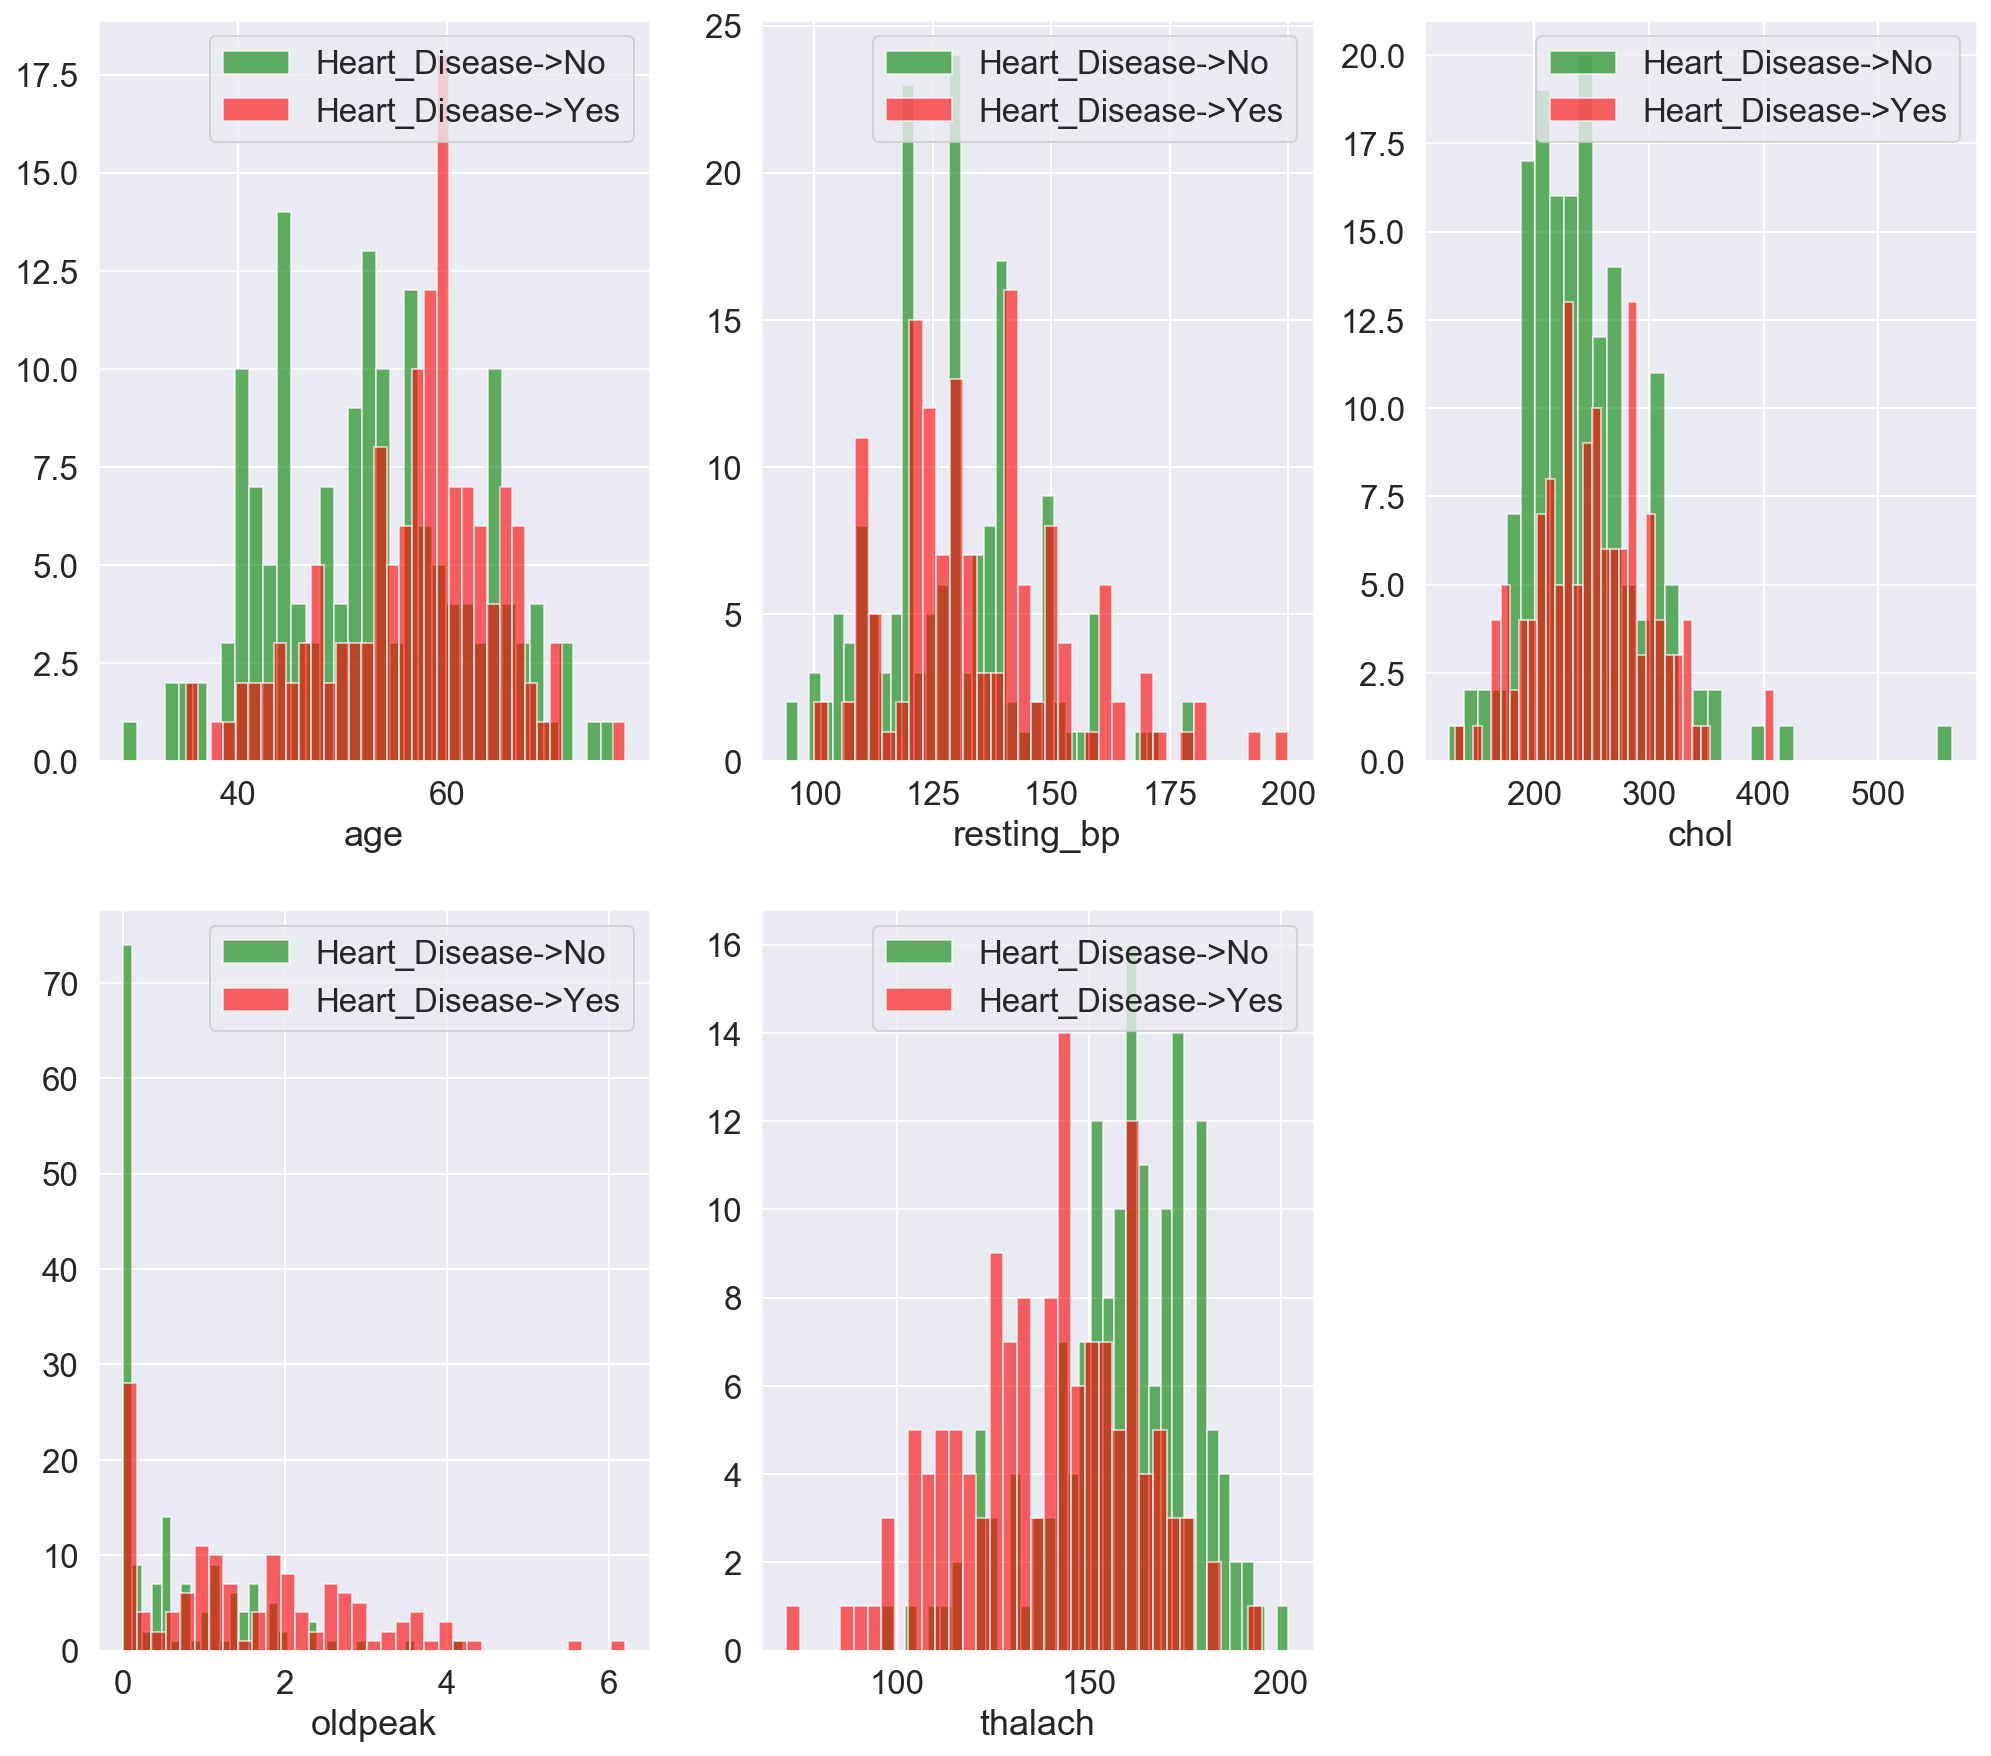

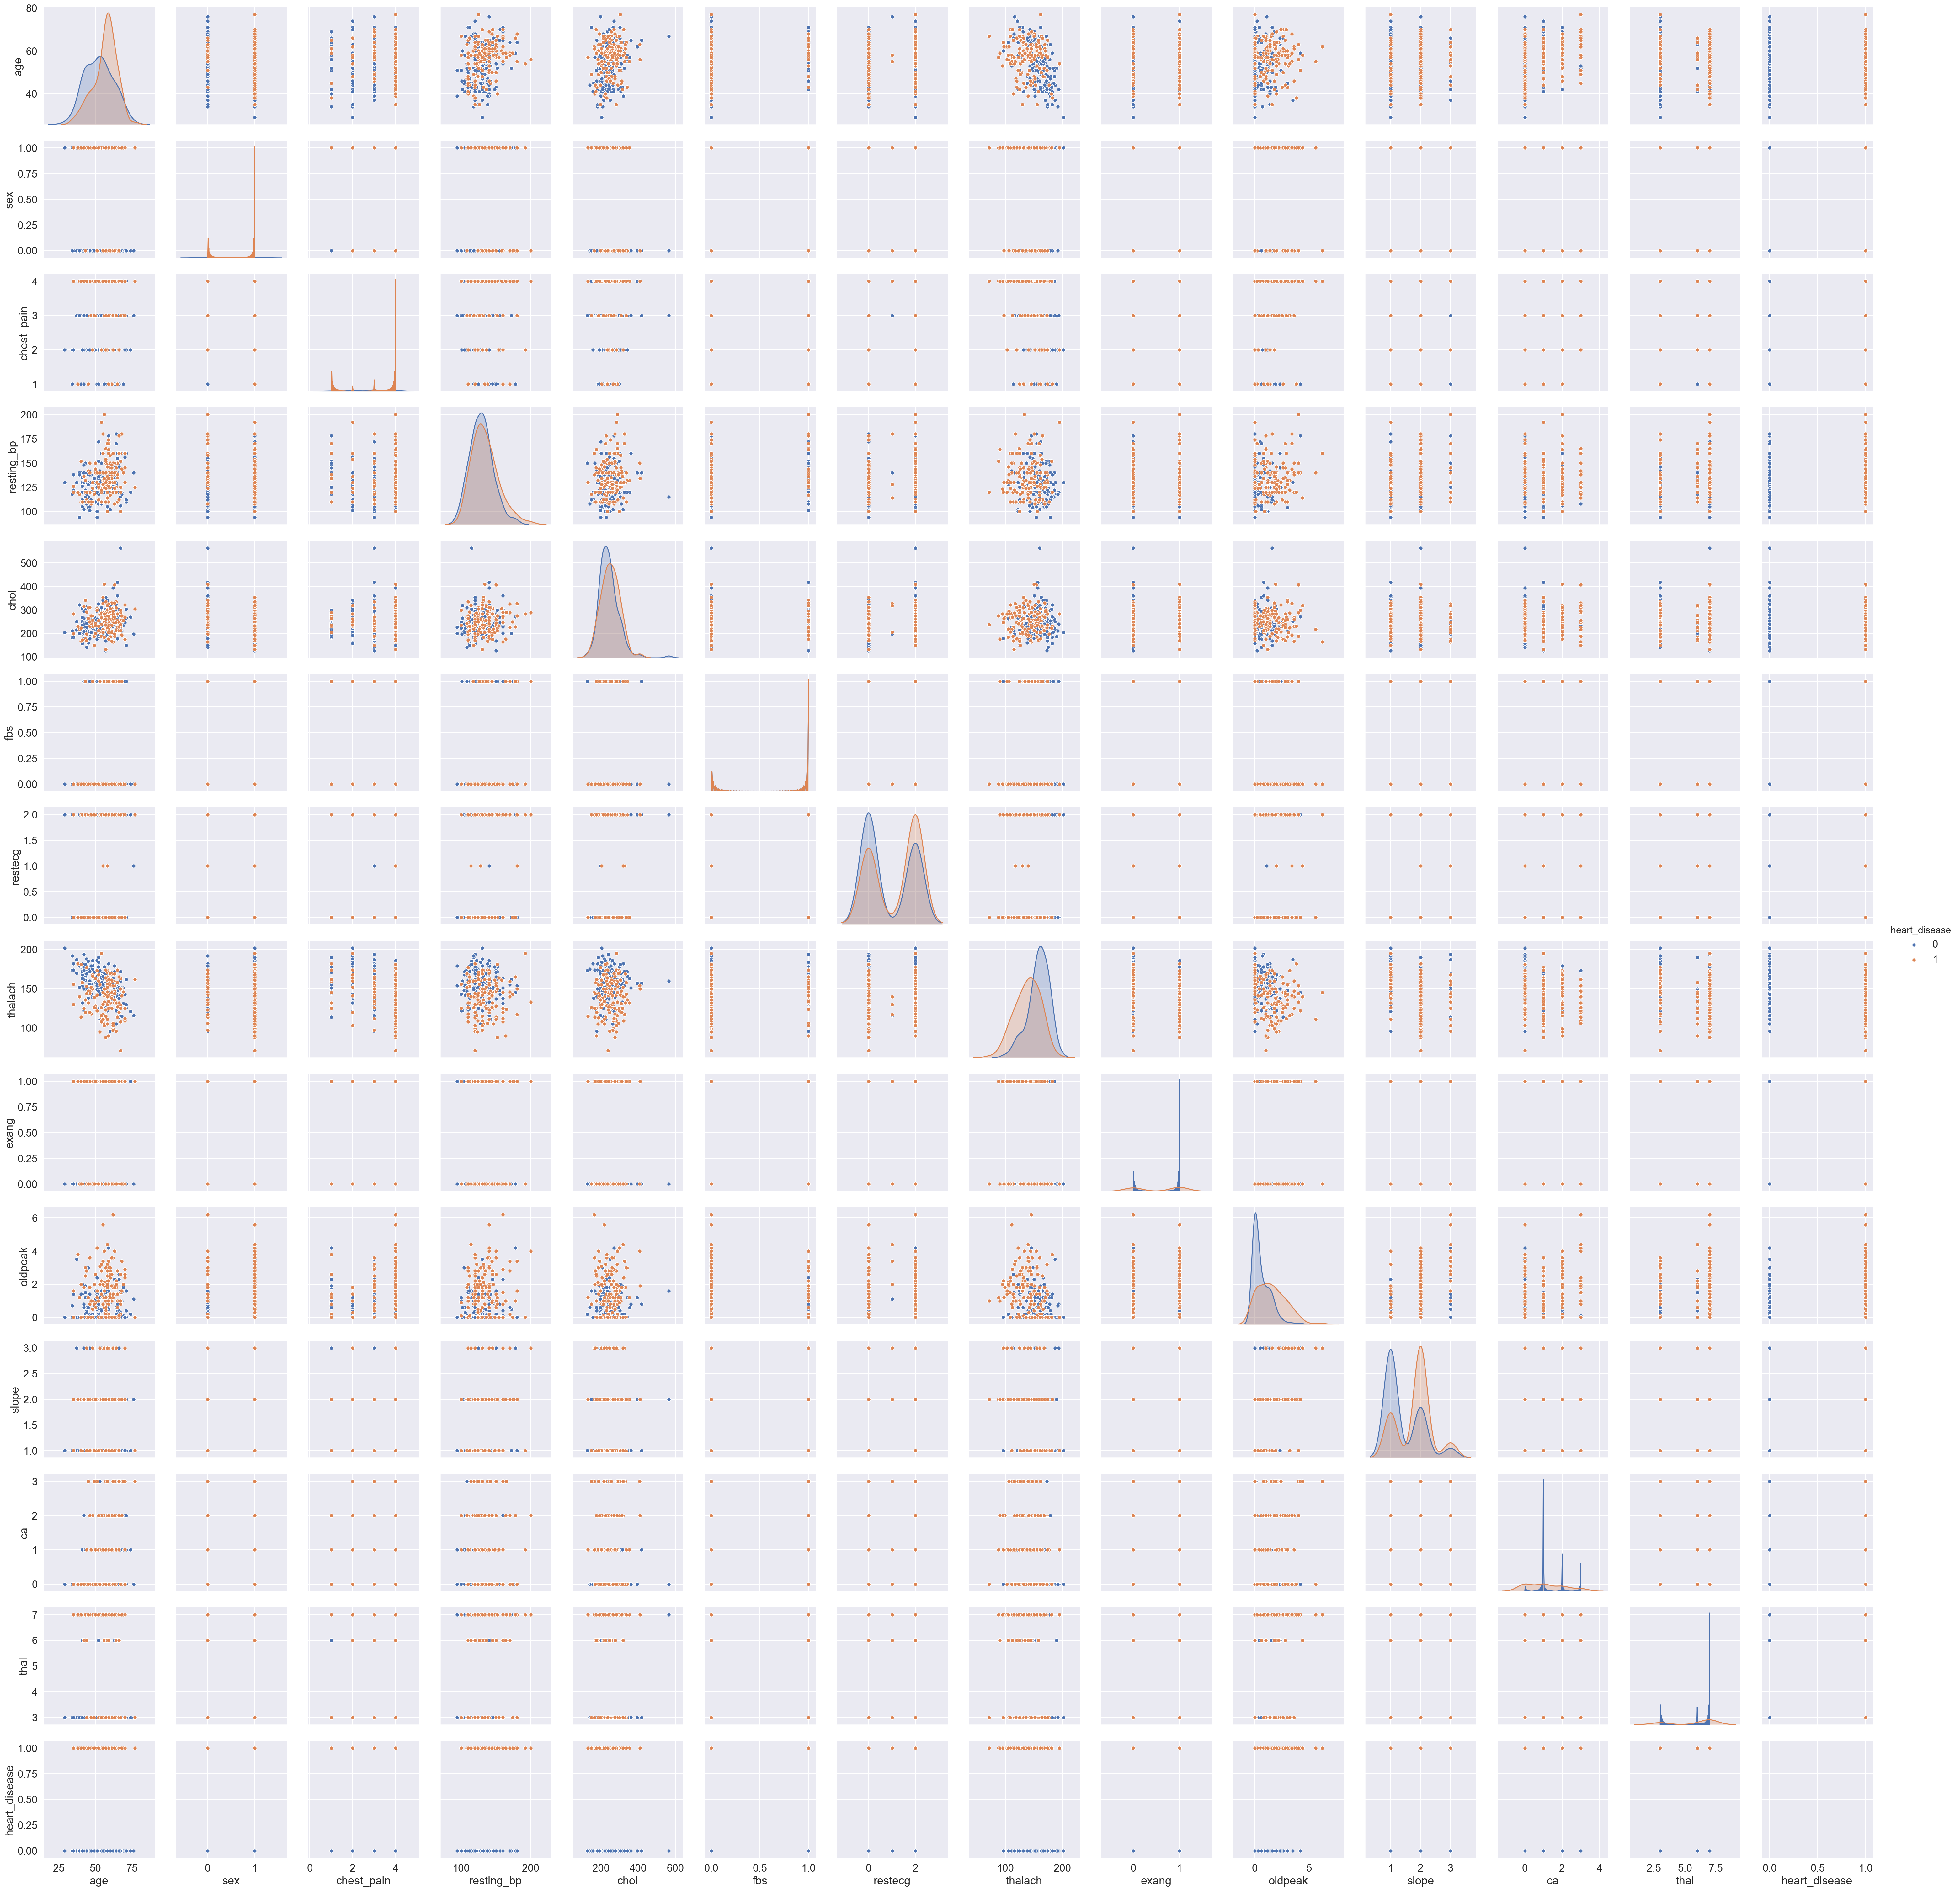

In [23]:
DataVisualizations(heartDF, target, categorical_features, continuous_features)

In [24]:
    
test_size = 0.2  # (80:20 train test split)
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig, y_train_orig, y_test_orig = TrainTestSplit_Standardization(heartDF, target, test_size)

(237, 13)
(237,)
(60, 13)
(60,)


Plotting correlation
------------


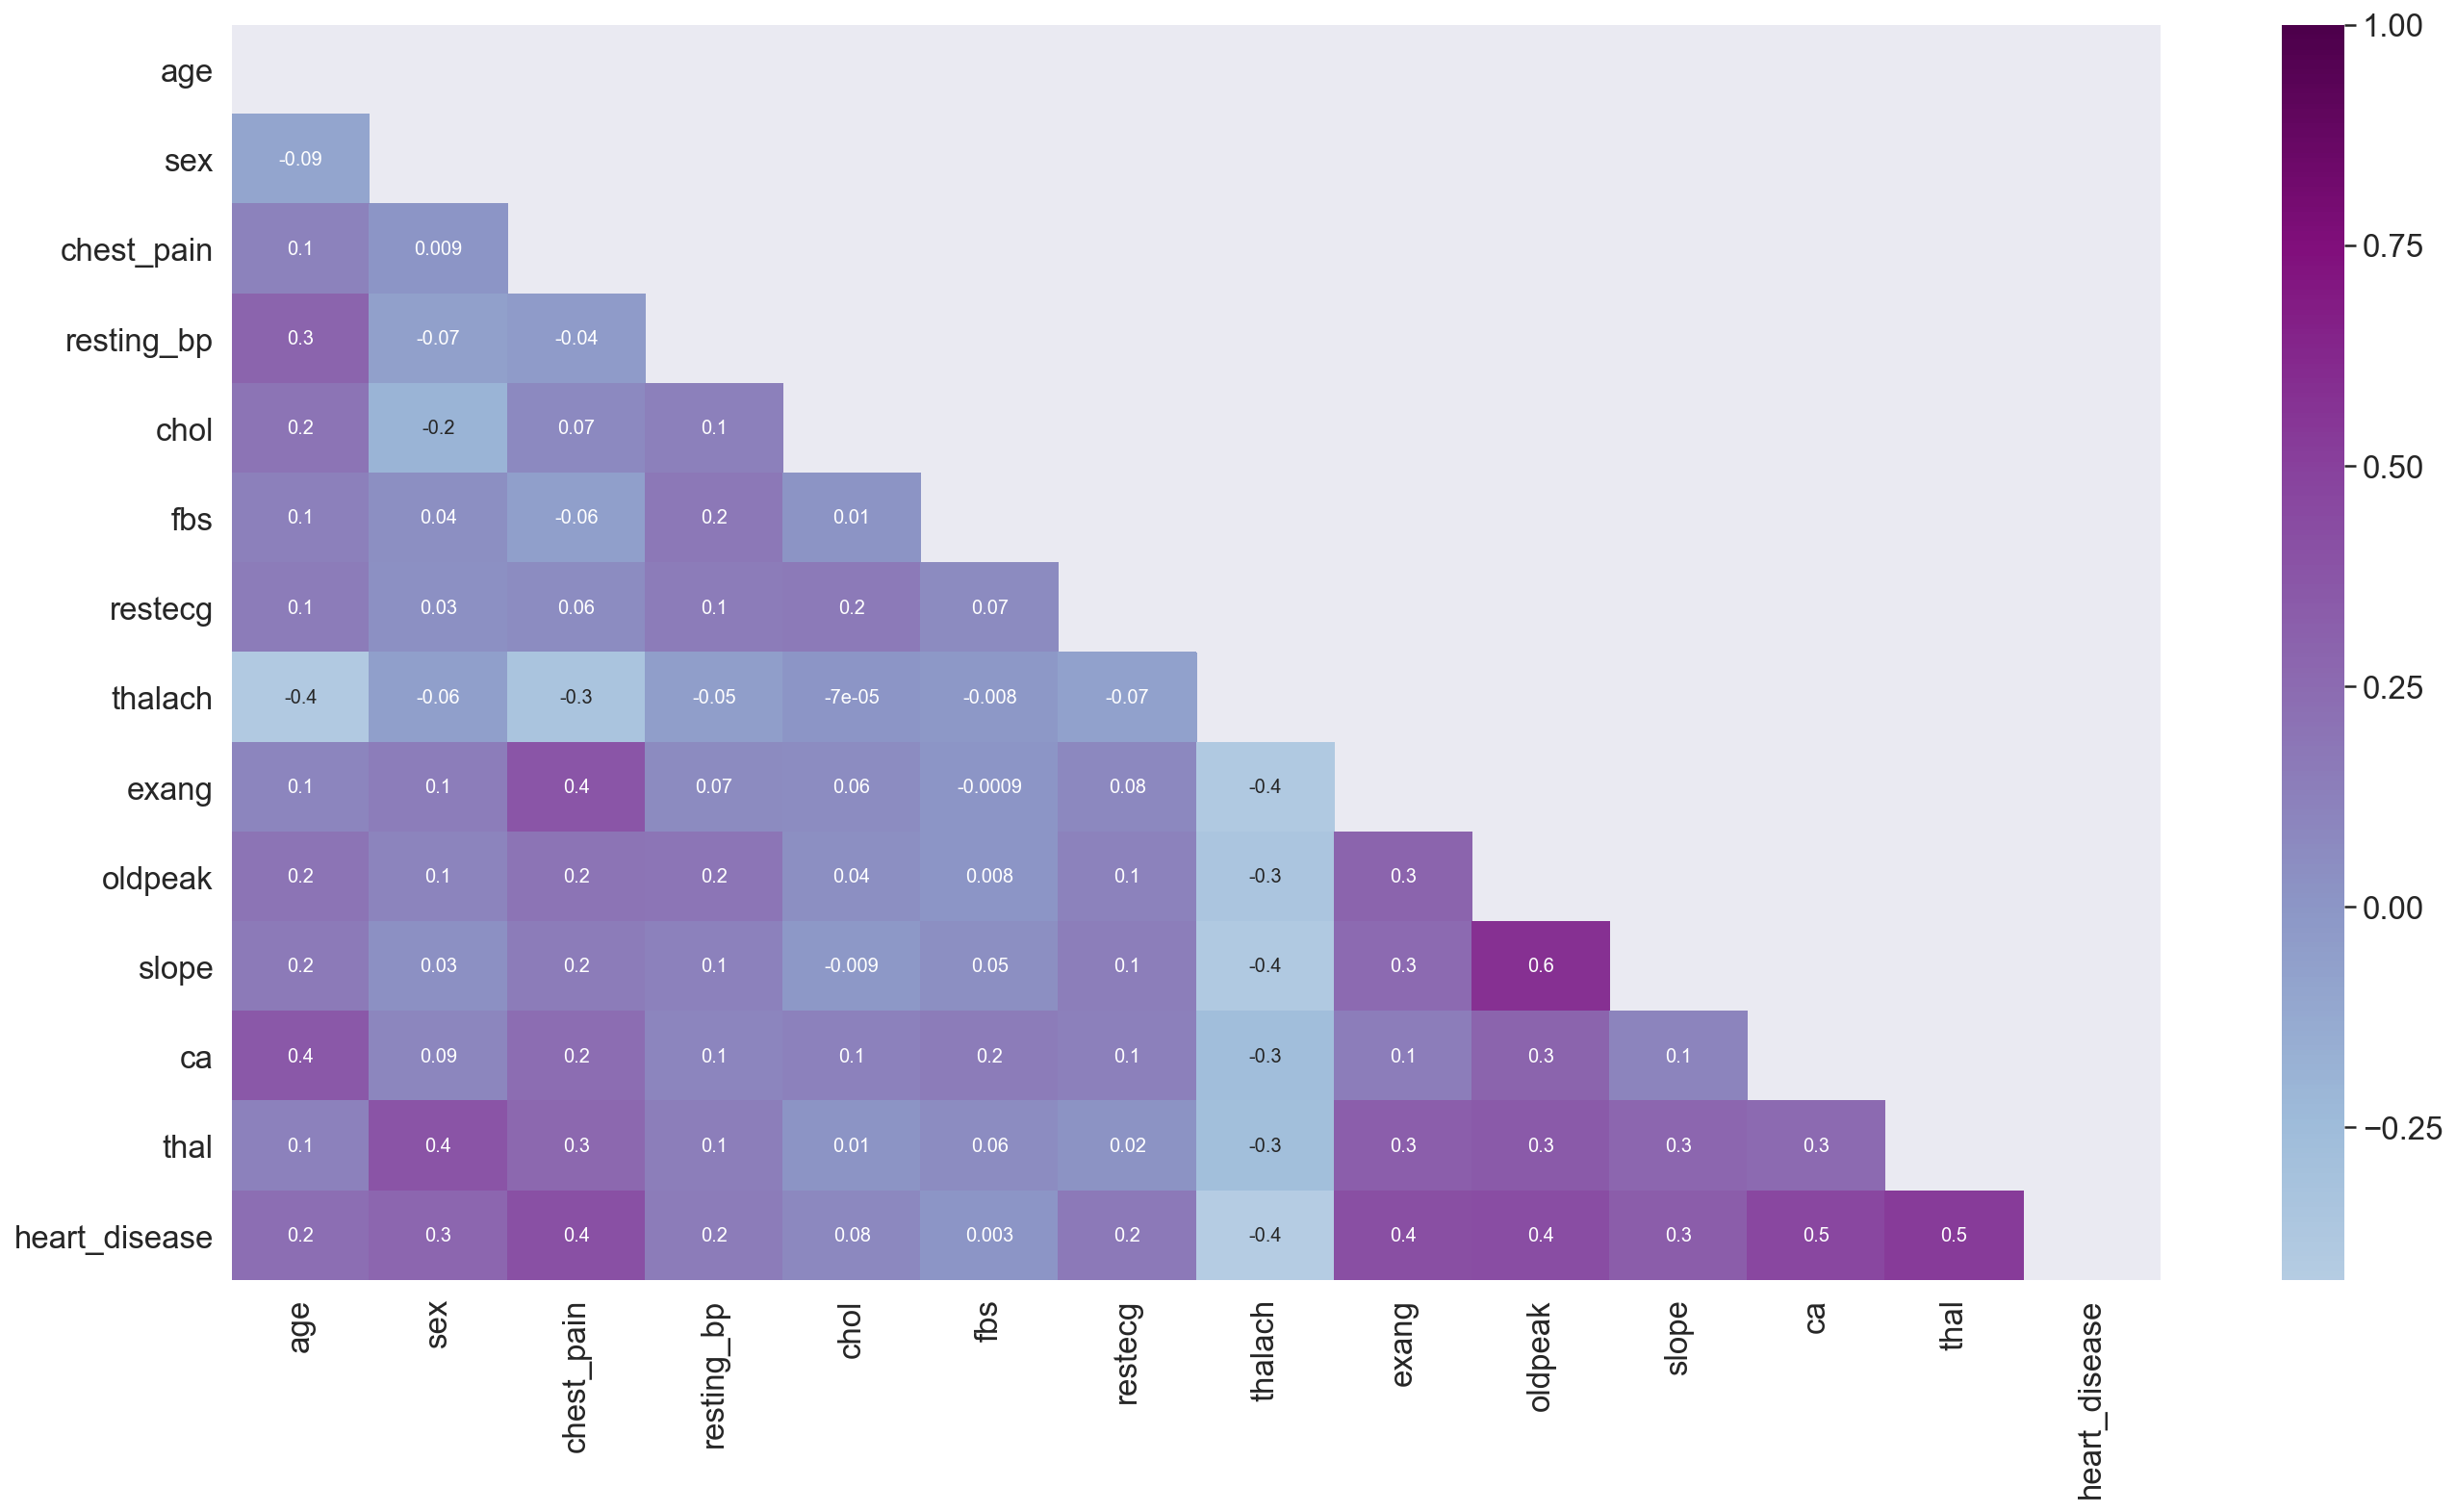

 
Plotting K-best features
------------
   Feature_Name      Score      p-values
11         thal  93.469920  7.881417e-19
1            ca  56.613123  1.122616e-12
2    chest_pain  54.687117  2.478634e-12
12      thalach  49.486653  2.165832e-11
4         exang  42.533594  4.212443e-10
6       oldpeak  41.469252  6.684113e-10
9           sex  25.215873  1.013587e-06
10        slope  19.585369  1.472987e-05
0           age  10.234260  1.568415e-03
7       restecg   7.207906  7.775249e-03
8    resting_bp   5.648897  1.826834e-02
3          chol   1.444721  2.305867e-01
 
Variation Inflation Factor
------------
         Features        VIF
3      resting_bp  60.917784
0             age  42.719806
7         thalach  36.776442
4            chol  26.158470
2      chest_pain  14.027296
10          slope  11.765073
12           thal  11.425012
13  heart_disease   3.964384
1             sex   3.923610
9         oldpeak   3.191434
11             ca   2.285916
6         restecg   2.188922
8       

In [25]:
featureSelection(heartDF, target, X_train, y_train)

#### Based on SelectKbest, VIF and correlation matrix, we drop few featues

In [26]:
X_train_new, X_test_new = selectedFeatures(X_train, X_test)

X_train:  (237, 10)
X_test:  (60, 10)


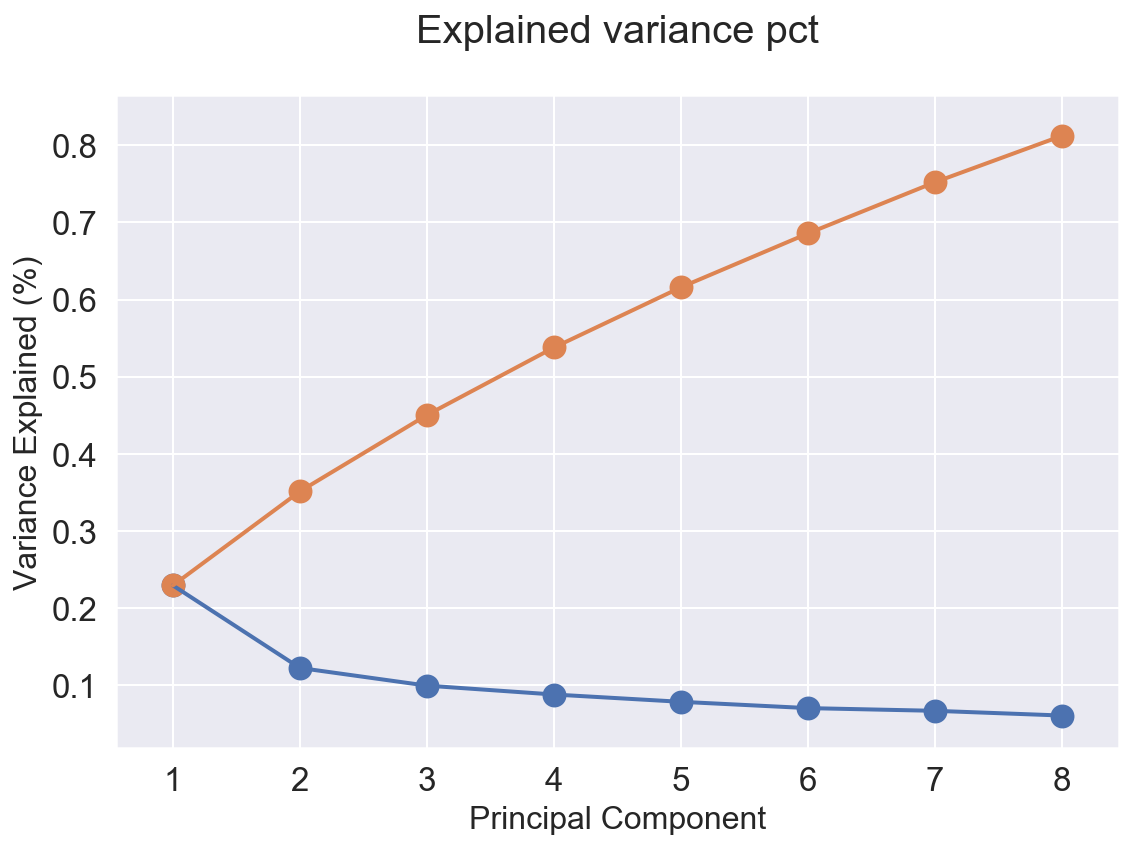

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
age         0.296410 -0.442651  0.077431 -0.127724  0.235070 -0.014890   
ca          0.300118 -0.150817  0.173714 -0.358186  0.208044  0.118226   
chest_pain  0.296476  0.182028 -0.342207 -0.363067  0.073129  0.033158   
chol        0.097175 -0.407083 -0.288588 -0.315065 -0.394692 -0.218212   
exang       0.309193  0.244710 -0.187731 -0.182100 -0.184764  0.019611   
fbs         0.074266 -0.128907  0.525965 -0.081166  0.331058  0.216511   
oldpeak     0.395843  0.042264 -0.029265  0.430922 -0.033026 -0.183419   
restecg     0.159660 -0.236951  0.047756  0.111533 -0.552761  0.712573   
resting_bp  0.157177 -0.388096  0.362498  0.105319 -0.236347 -0.423576   
sex         0.116841  0.446984  0.458882 -0.156779 -0.252690  0.120905   
slope       0.367905  0.056174 -0.088416  0.567843  0.036749  0.013983   
thal        0.335262  0.307299  0.238316 -0.167424 -0.205120 -0.339140   
thalach    -0.394105 -0.005465  0.204526 -0.016604 -0.356120 -0.197926   

                PCA7      PCA8  
age        -0.160358 -0.415119  
ca         -0.472443  0.313007  
chest_pain  0.178288  0.257970  
chol        0.042969  0.262764  
exang       0.498001 -0.297522  
fbs         0.586019  0.364087  
oldpeak    -0.150781  0.290712  
restecg    -0.018214  0.014964  
resting_bp  0.205848 -0.241459  
sex        -0.233545 -0.204947  
slope       0.043922  0.171340  
thal       -0.063839  0.080922  
thalach     0.006198  0.389976

In [27]:
# PCA
PCA_df, X_train_pca, X_test_pca = PCA(X_train, X_test)
PCA_df.head(14)

### Base models with all features

In [28]:
n_splits = 5 # 5 fold cross validation

#base_classifiers

base_classifiers = []
base_classifiers.append(('LR', LogisticRegression()))
base_classifiers.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
base_classifiers.append(('SVM', SVC()))
base_classifiers.append(('DT', DecisionTreeClassifier()))
base_classifiers.append(('ADA_Boost', AdaBoostClassifier()))
base_classifiers.append(('Gradient_Boost', GradientBoostingClassifier()))

base_classifiers.append(('Bagging',BaggingClassifier( base_estimator=KNeighborsClassifier(n_neighbors=5),#LogisticRegression(max_iter=10000),
                                   n_estimators=100 )))
base_classifiers.append(('RF', RandomForestClassifier()))

fitted_classifiers = baseModelFitting(base_classifiers, n_splits, X_train, X_test, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.81      0.75      0.78        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             27              5
True_Yes             7             21
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.79      0.79      0.79        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

 
Confusion Matrix
          Predicted_No  Predicte

### Base models with selected features (X_train_new, X_test_new)

In [29]:
n_splits = 5 # 5 fold cross validation

fitted_classifiers_selectedFeatures = baseModelFitting(base_classifiers, n_splits, X_train_new, X_test_new, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.78      0.75      0.76        28

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             26              6
True_Yes             7             21
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        32
           1       0.77      0.86      0.81        28

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60

 
Confusion Matrix
          Predicted_No  Predicte

### Base models with PCA features (X_train_pca, X_test_pca)

In [30]:
n_splits = 5 # 5 fold cross validation

fitted_classifiers_PCA = baseModelFitting(base_classifiers, n_splits, X_train_pca, X_test_pca, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.79      0.79      0.79        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             26              6
True_Yes             6             22
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

 
Confusion Matrix
          Predicted_No  Predicte

### Grid Searches

#### Grid search Params

In [31]:
lr_params = {'C': np.logspace(-4, 4, 5),
             'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'class_weight':['balanced', None, 'auto'],
             'fit_intercept': [True, False]}

knn_params = {
                'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
             }

DT_classifier_params = {
                        'max_depth': list(range(1, 5))+[None], #How many nodes deep can the decision tree go?
                        'criterion' :['gini', 'entropy'], # for classification
                        'max_features': [None, 'auto'],# 'sqrt', 'log2'],   #Is there a cutoff to the number of features to use?
                        'max_leaf_nodes': list(range(4, 5)), #How many leaves can be generated per tree?
                        'min_samples_split': [2, 5, 10],#, 20, 30, 50], #How many samples need to be included at a node, at a minimum?    
                        'min_samples_leaf': [1, 2],#, 3,4] #How many samples need to be included at a leaf, at a minimum?                          
                        'class_weight':['balanced', None, 'auto'],  # if not using SMOTE etc to balance the class 
                        'ccp_alpha': [0, 0.001, 0.005, 0.01] #Associate a cost with the number of terminal nodes, for pruing, less alpha means larget cost
                       
                        }

Bagging_params = {'n_estimators': [10, 40]#, #, 100], 
                 # 'max_leaf_nodes':[10, 15]#, 
                 # 'max_depth':[4, 5, 6],
                 # 'max_samples':[5, 50],#[np.linspace(0.5, 1.0, 3)],# is the number of samples to draw from X to train each base estimator
                 # 'max_features':[5, 8],# [np.linspace(0.5, 1.0, 3)], #range(int(3/4.*X.shape[1]), X.shape[1]+1), # is the number of features to draw from X to train each base estimator, can be given as absolute number or fraction.
                  #'bootsrap':[True], # whether SAMPLES are drawn with replacement
                 # 'bootstrap_features':[True],  # whether FEATURES are drawn with replacement
                 # 'oob_score':[True], # Whether to use out-of-bag samples to estimate the generalization error
                 # 'warm_start':[False] #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new ensemble
                 }


RF_params = {
                'n_estimators': [10, 100, 200],
                'max_features': ['auto'],#, 'sqrt', 'log2', None],   #Is there a cutoff to the number of features to use?
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], #How many nodes deep can the decision tree go?
                'criterion' :['gini', 'entropy'], # for classification
                'max_leaf_nodes': list(range(1, 12, 2))+[None]#, #How many leaves can be generated per tree?
                #  'min_samples_split': [2, 5, 10, 20, 30, 50], #How many samples need to be included at a node, at a minimum?    
                 # 'min_samples_leaf': [1, 2, 3,4],#How many samples need to be included at a leaf, at a minimum?                          
                 # 'class_weight':['balanced', None, 'auto'],  # if not using SMOTE etc to balance the class 
                 # 'ccp_alpha': [0, 0.001, 0.005, 0.01], #Associate a cost with the number of terminal nodes, for pruing, less alpha means larget cost
                 # 'max_samples': [5, 10, 20],
                 # 'bootstrap': [True, False],
                 # 'oob_score':[True]
                }


ada_params = {'n_estimators': [50, 100, 200, 500],
              'base_estimator' : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3),
                                  DecisionTreeClassifier(max_depth=4)]}

gb_params = {'n_estimators': [200, 500, 1000],
            'learning_rate': [0.02, 0.05],
            'max_depth': [1, 2],
            'min_samples_leaf': [5,10],
            'min_samples_split': [5,10]} 


SVM_params = { 'C': [0.1, 1, 10, 100, 1000],#[np.logspace(-5, 2, 5)]#,  # regularization parameter
               'gamma': [1e-3, 1e-4], #['auto']#,#'auto_deprecated', 'scale', ],
               'kernel': ['rbf','linear']# ,'poly','sigmoid', 'precomputed']#, 
              } 

grid_search_params = [lr_params, knn_params, SVM_params, DT_classifier_params, 
                     ada_params, gb_params, Bagging_params, RF_params]
#grid_search_params

### Gridsearch with all features (X_train, X_test)

In [32]:
best_gs_classifiers = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train, X_test, y_train, y_test)

Classifier:  LR
model cross val score: 0.830
model best score: 0.843
model test score: 0.800
----------------------
Classifier:  KNN
model cross val score: 0.843
model best score: 0.848
model test score: 0.800
----------------------
Classifier:  SVM
model cross val score: 0.852
model best score: 0.852
model test score: 0.783
----------------------
Classifier:  DT
model cross val score: 0.763
model best score: 0.806
model test score: 0.717
----------------------
Classifier:  ADA_Boost
model cross val score: 0.772
model best score: 0.810
model test score: 0.783
----------------------
Classifier:  Gradient_Boost
model cross val score: 0.843
model best score: 0.856
model test score: 0.800
----------------------
Classifier:  Bagging
model cross val score: 0.827
model best score: 0.822
model test score: 0.750
----------------------
Classifier:  RF
model cross val score: 0.826
model best score: 0.852
model test score: 0.800
----------------------


### Gridsearch with selected features (X_train_new, X_test_new)

In [33]:
best_gs_classifiers_sltd_features = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train_new, X_test_new, y_train, y_test)

Classifier:  LR
model cross val score: 0.852
model best score: 0.856
model test score: 0.800
----------------------
Classifier:  KNN
model cross val score: 0.848
model best score: 0.852
model test score: 0.783
----------------------
Classifier:  SVM
model cross val score: 0.848
model best score: 0.860
model test score: 0.800
----------------------


KeyboardInterrupt: 

### Gridsearch with PCA features (X_train_pca, X_test_pca)

In [ ]:
# X_train_pca, X_test_pca,

best_gs_classifiers_pca = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train_pca, X_test_pca, y_train, y_test)

In [ ]:
#best_gs_classifiers

### Printing Evaluation metrics only for the best model & features

In [34]:
# Classification report
print('Classification report')
predictions = best_gs_classifiers['RF']['Best Estimator'].predict(X_test)
print(classification_report(y_test, predictions))
            
print(' ')
print('Confusion Matrix')
            
labels=[0, 1]
confusion_mat = confusion_matrix(y_test, predictions, labels=labels)
            
confusion_mat = pd.DataFrame(confusion_mat,
columns=['Predicted_No', 'Predicted_Yes'],
index=  ['True_No', 'True_Yes'])
            
print(confusion_mat)
            

Classification report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.79      0.79      0.79        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             26              6
True_Yes             6             22


In [35]:
# For plotting ROC and Precision-Recall curves

import scikitplot as skplt

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

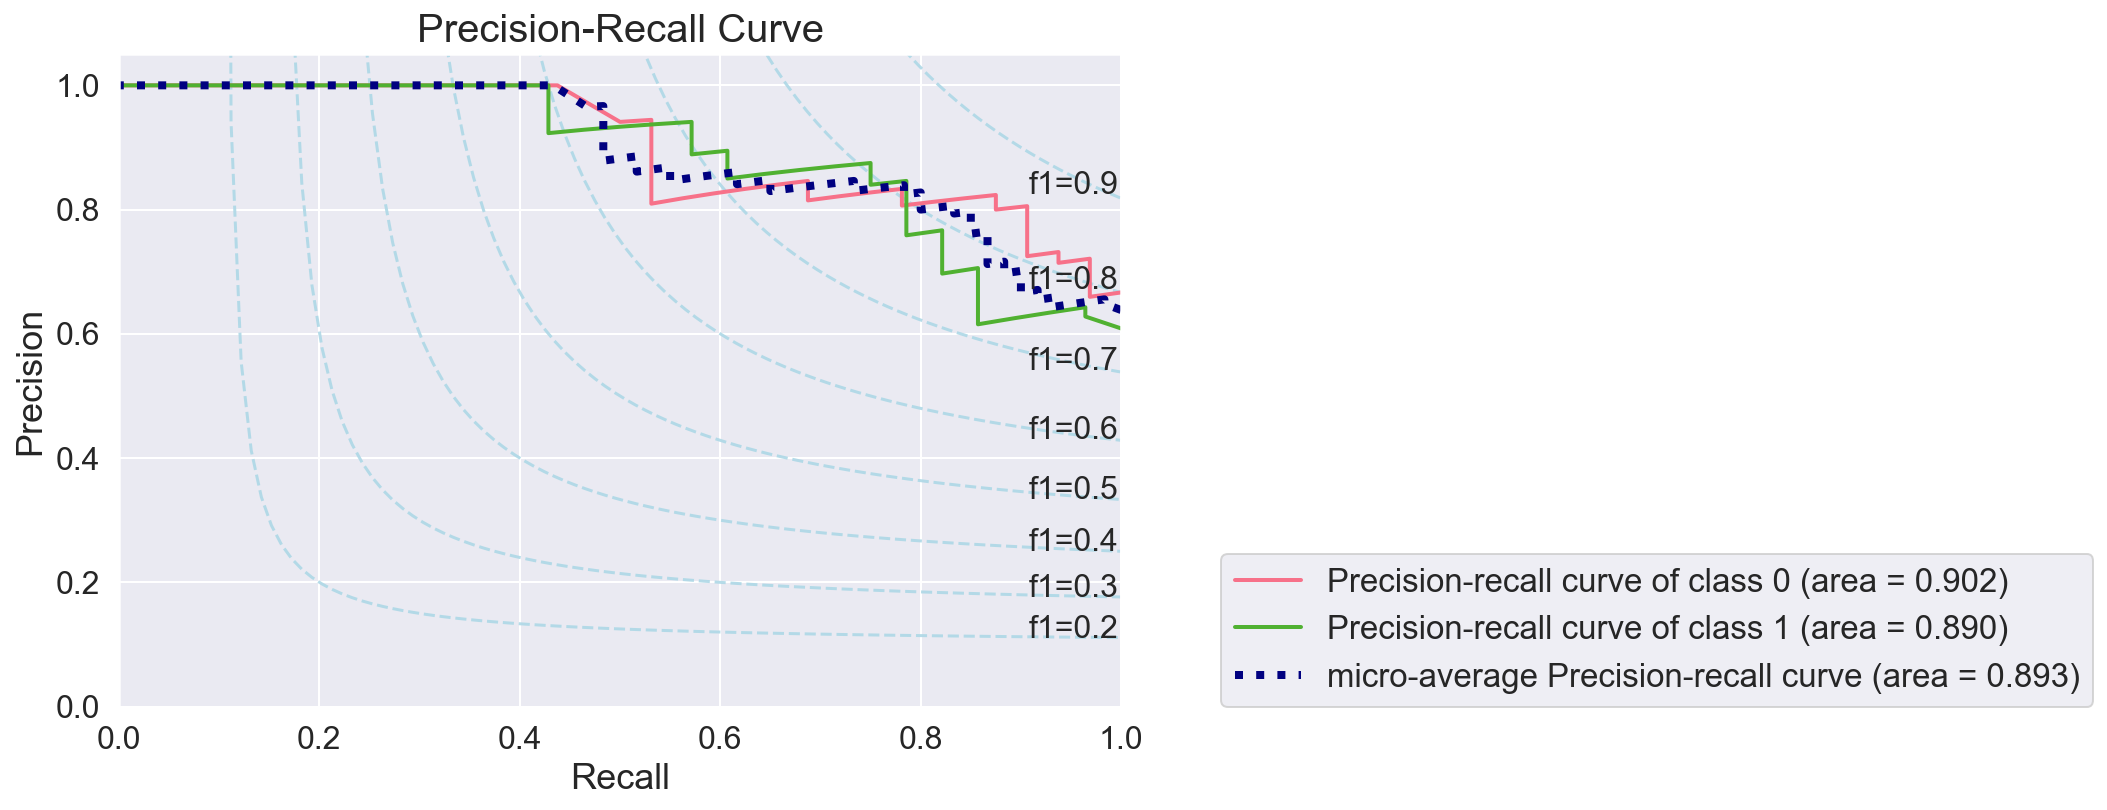

In [36]:
# Recall Precision plot

probabilities = best_gs_classifiers['RF']['Best Estimator'].predict_proba(X_test)

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()


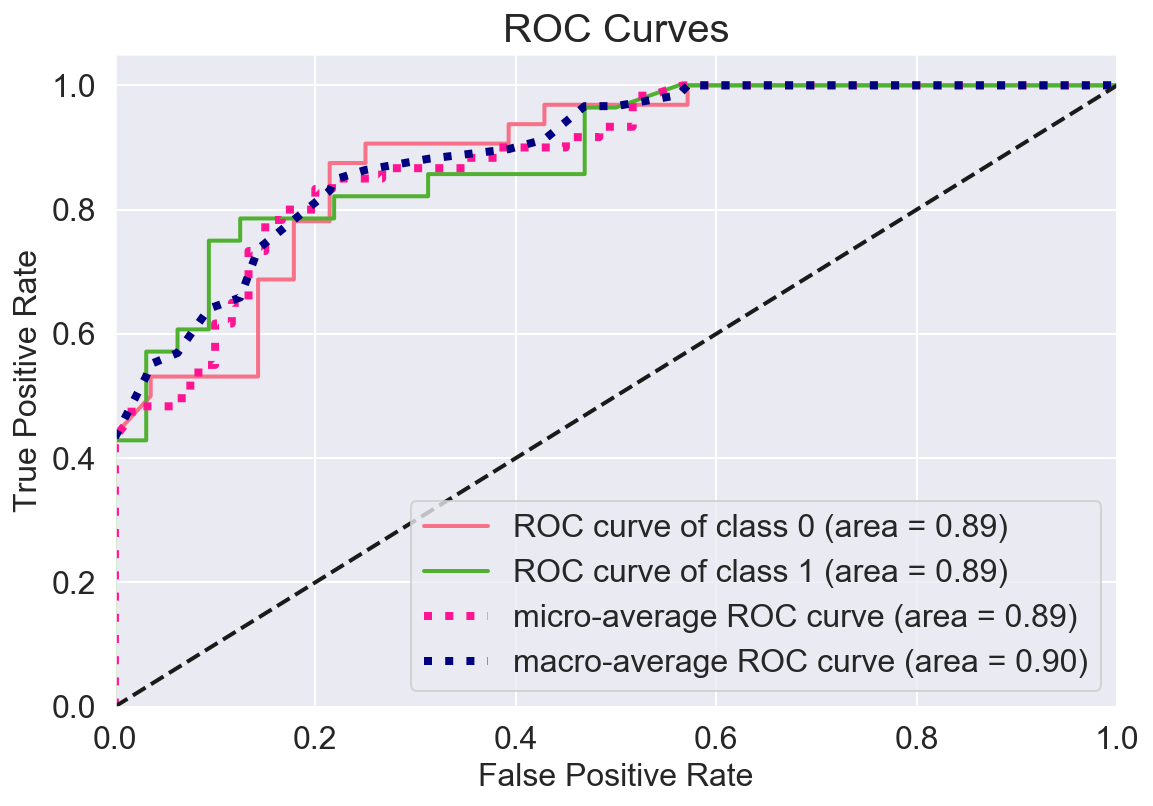

In [37]:
# AUC ROC plot

probabilities = best_gs_classifiers['RF']['Best Estimator'].predict_proba(X_test)

skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

In [38]:
# Feature importance

feature_importance = best_gs_classifiers['RF']['Best Estimator'].feature_importances_ #coef_[0]
                  
feature_importanceDF = pd.DataFrame({'variable': X_train.columns,
                             'coef': feature_importance,
                             'abs_coef': np.abs(feature_importance), 
                            })
feature_importanceDF.sort_values(by='abs_coef', ascending=False).head(12)

variable      coef  abs_coef
11        thal  0.265303  0.265303
2   chest_pain  0.203228  0.203228
1           ca  0.149983  0.149983
6      oldpeak  0.109651  0.109651
12     thalach  0.092444  0.092444
4        exang  0.057609  0.057609
9          sex  0.046226  0.046226
3         chol  0.026484  0.026484
0          age  0.025379  0.025379
8   resting_bp  0.023692  0.023692
5          fbs  0.000000  0.000000
7      restecg  0.000000  0.000000

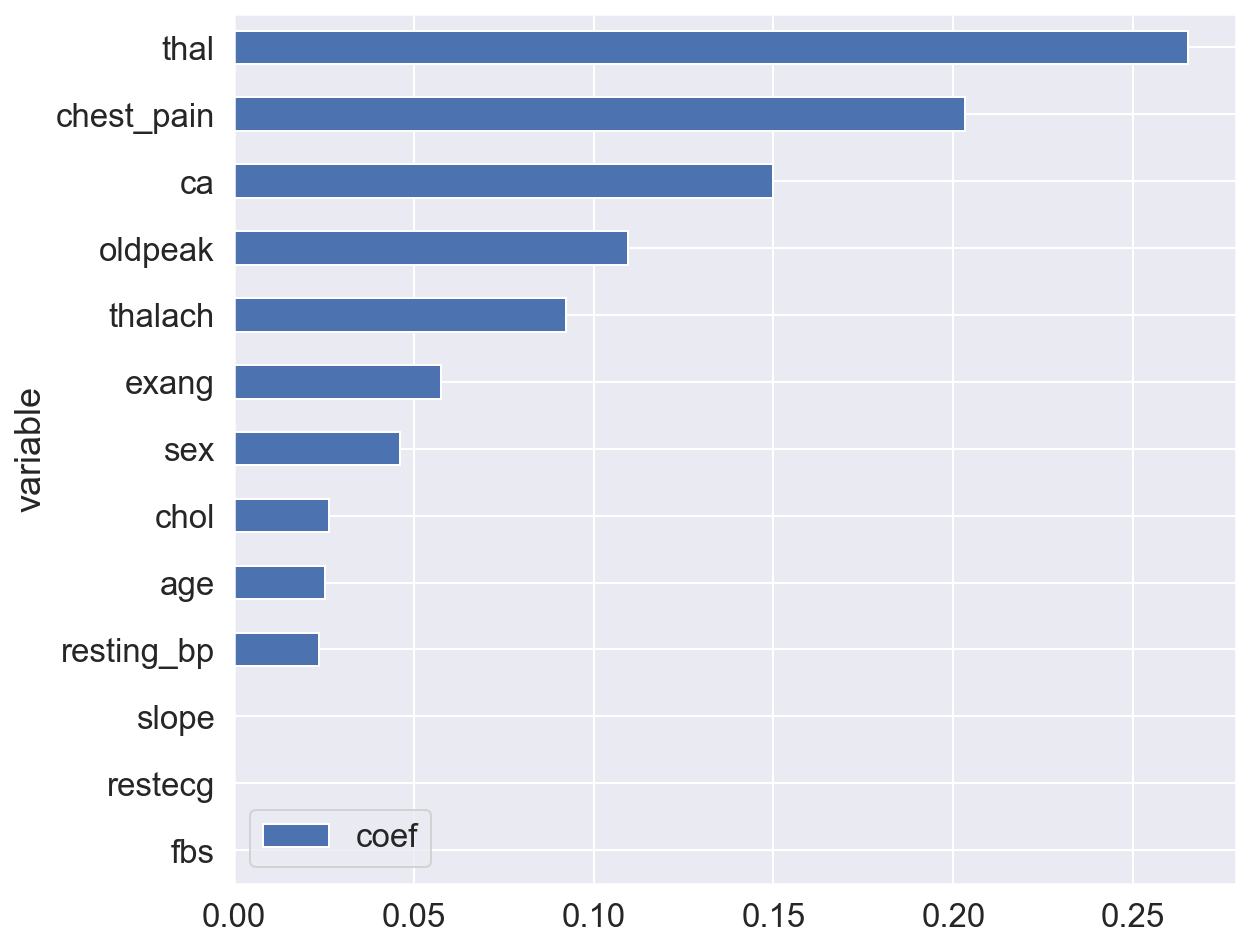

In [39]:
feature_importanceDF.sort_values(by='abs_coef', ascending=True).plot(kind='barh',  y='coef', x='variable',
                      color='b', figsize=(8, 8))
plt.show()

### 1. Model Interpretability - Shap

In [40]:
'''SHAP Values (an acronym from SHapley Additive exPlanations) break down a 
prediction to show the impact of each feature. 
'''

'SHAP Values (an acronym from SHapley Additive exPlanations) break down a \nprediction to show the impact of each feature. \n'

In [44]:
pip install shap

     |████████████████████████████████| 327kB 4.5MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-macosx_10_9_x86_64.whl size=378808 sha256=fb85d8a743837acea827dc917e3f95a85df8645459c6619ec466438349df419d
  Stored in directory: /Users/abhi/Library/Caches/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


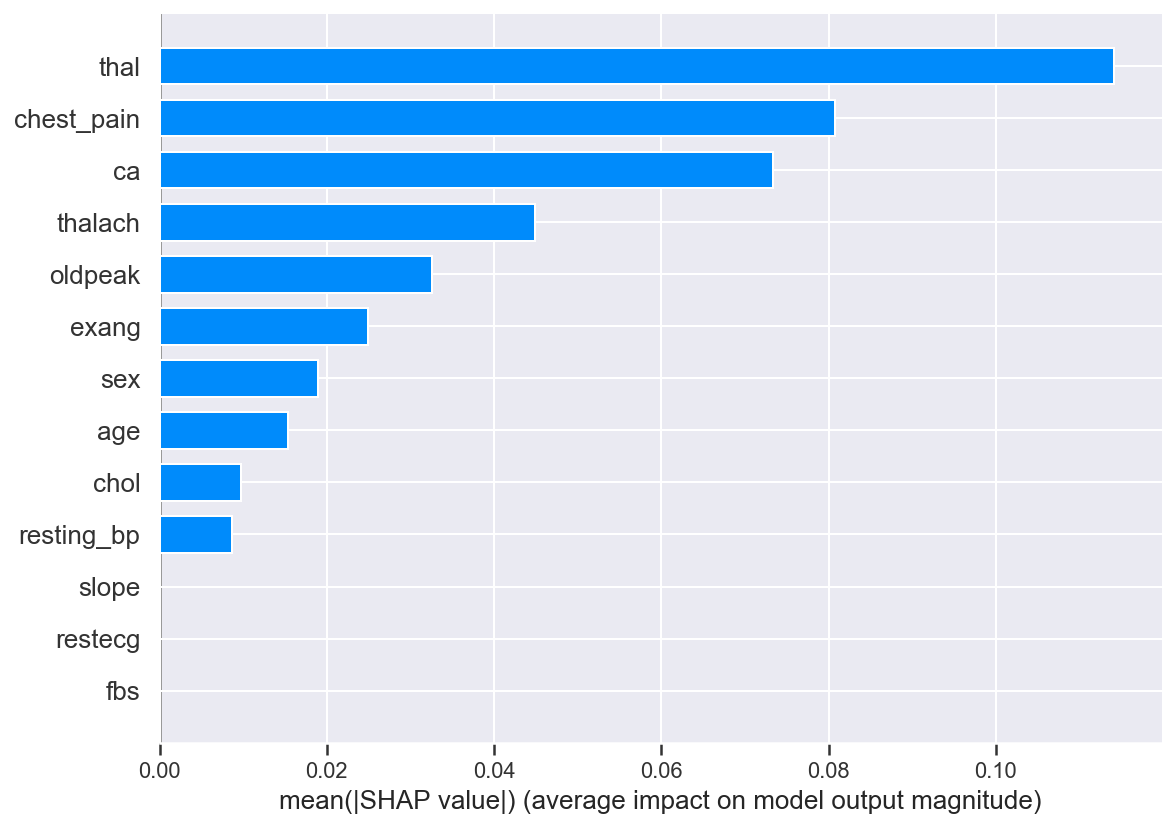

In [45]:
import shap 

model = best_gs_classifiers['RF']['Best Estimator']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

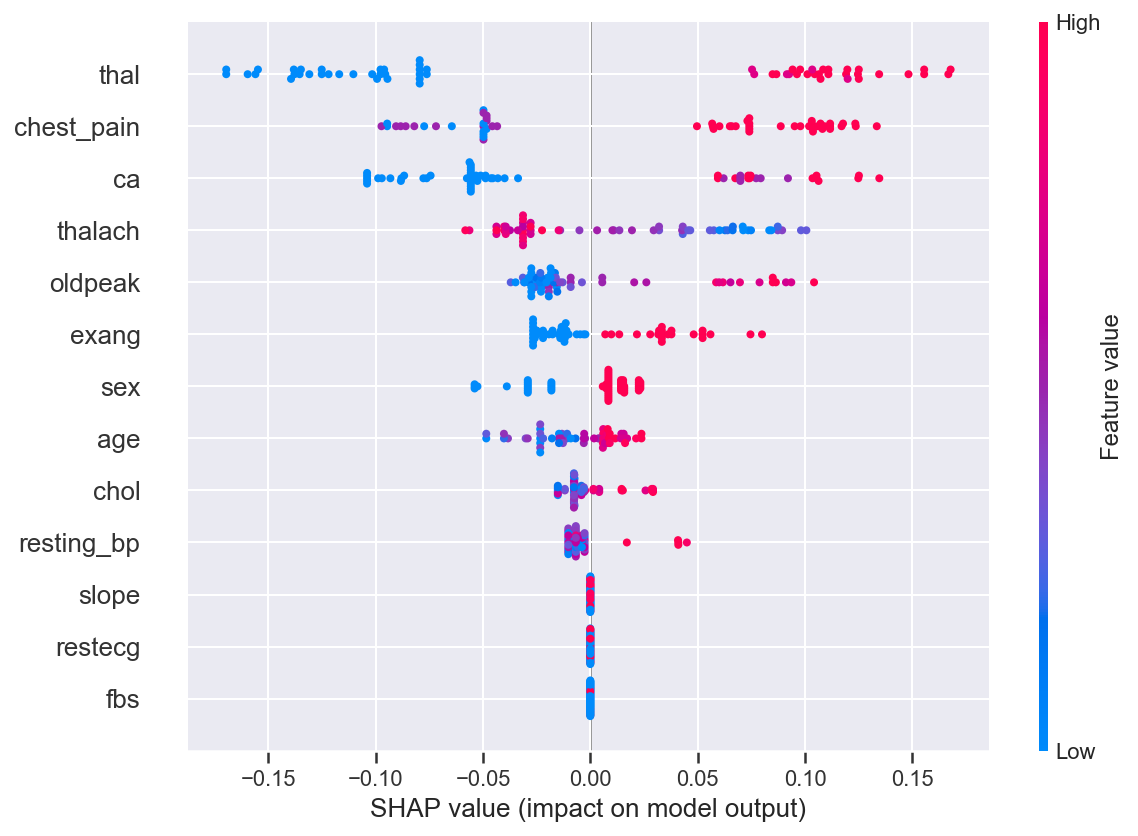

In [46]:
shap.summary_plot(shap_values[1], X_test)

In [48]:
# use Kernel SHAP to explain test set predictions

def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [47]:
data_for_prediction = X_test.iloc[1,:].astype(float)  # 1st row of data
data_for_prediction

age          -1.383006
ca           -0.734140
chest_pain    0.919056
chol          1.278390
exang         1.469694
fbs          -0.436984
oldpeak       0.688010
restecg      -1.032203
resting_bp    0.242022
sex           0.707107
slope         0.610089
thal          0.667953
thalach      -1.082237
Name: 1, dtype: float64

In [49]:
#data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [ ]:
# Prediction for this patient is 67% heart failure

In [51]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train.iloc[:50])# 50 rows
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

In [ ]:
'''It shows the predictions and influencing factors for many (in this case 50) 
patients, all together. It's also interactive, which is great. Hover over to see 
why each person ended up either red (prediction of disease) or blue (prediction of no disease),
'''

### 2. Model Interpretability - Lime

In [62]:
pip install lime

     |████████████████████████████████| 276kB 3.3MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=26207489e712d2a34a3ba0cb5c9f770185faebfa486f5934f4aee32885c4e487
  Stored in directory: /Users/abhi/Library/Caches/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [65]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Disease_Yes', 'Disease_No'],
    mode='classification'
)

In [66]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)

### 3. PDP (Partial Dependence Plot )

In [52]:
'''Partial Dependence Plot (learn more here). These plots vary a single variable 
in a single row across a range of values and see what effect it has on the outcome.
It does this for several rows and plots the average effect'''

'Partial Dependence Plot (learn more here). These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect'

In [58]:
pip install pdpbox

     |████████████████████████████████| 57.7MB 12.1MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690723 sha256=a2297541c592c2660cd03dc20b2dc4ddb5e0f5587e2d3345f1f62bd87d0173c1
  Stored in directory: /Users/abhi/Library/Caches/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pdpbox import pdp, info_plots

base_features = heartDF.columns.values.tolist()
base_features.remove(target)

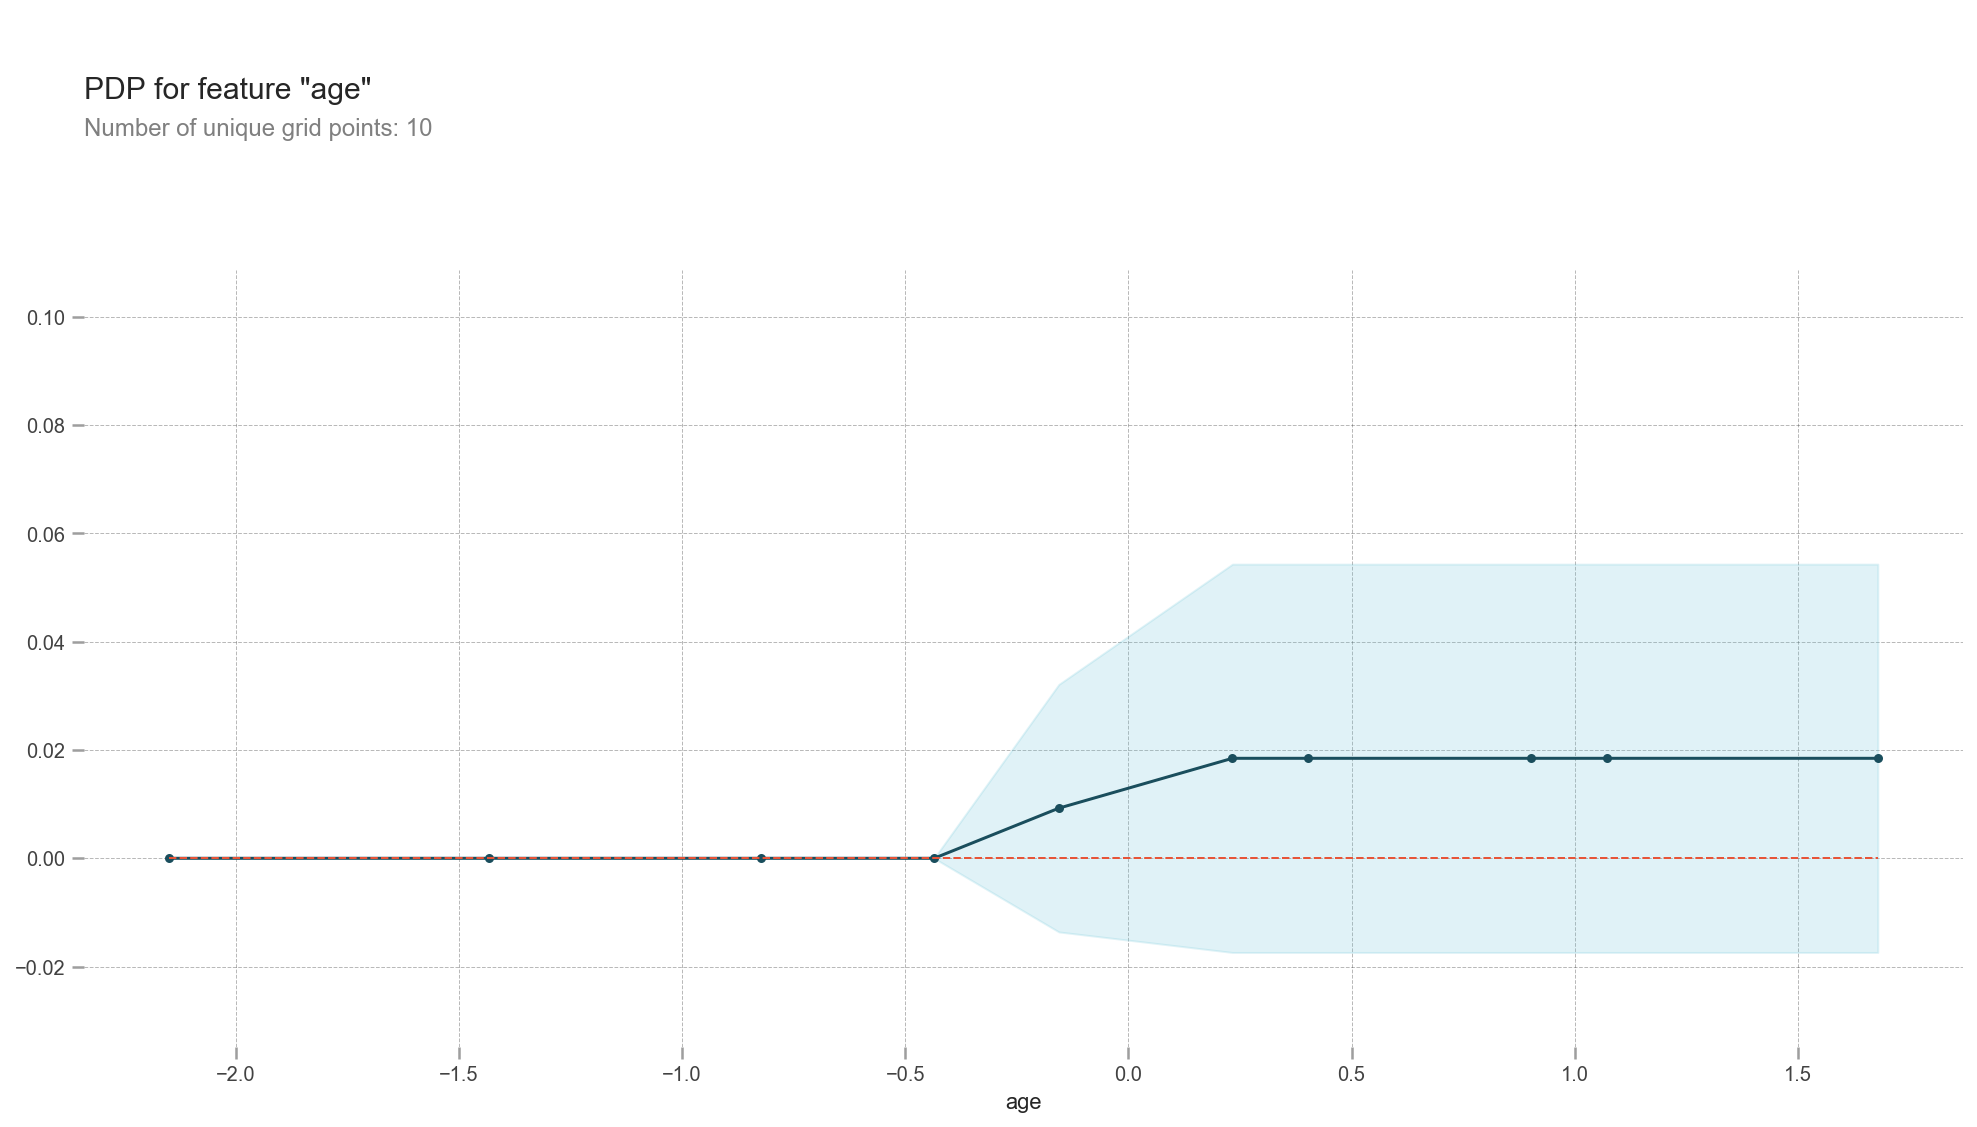

In [61]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [ ]:
# Higher the age, more is the probability of heart disease. Although it plateaus 
# after certain age (Note: we are looking at normalized value of the age)

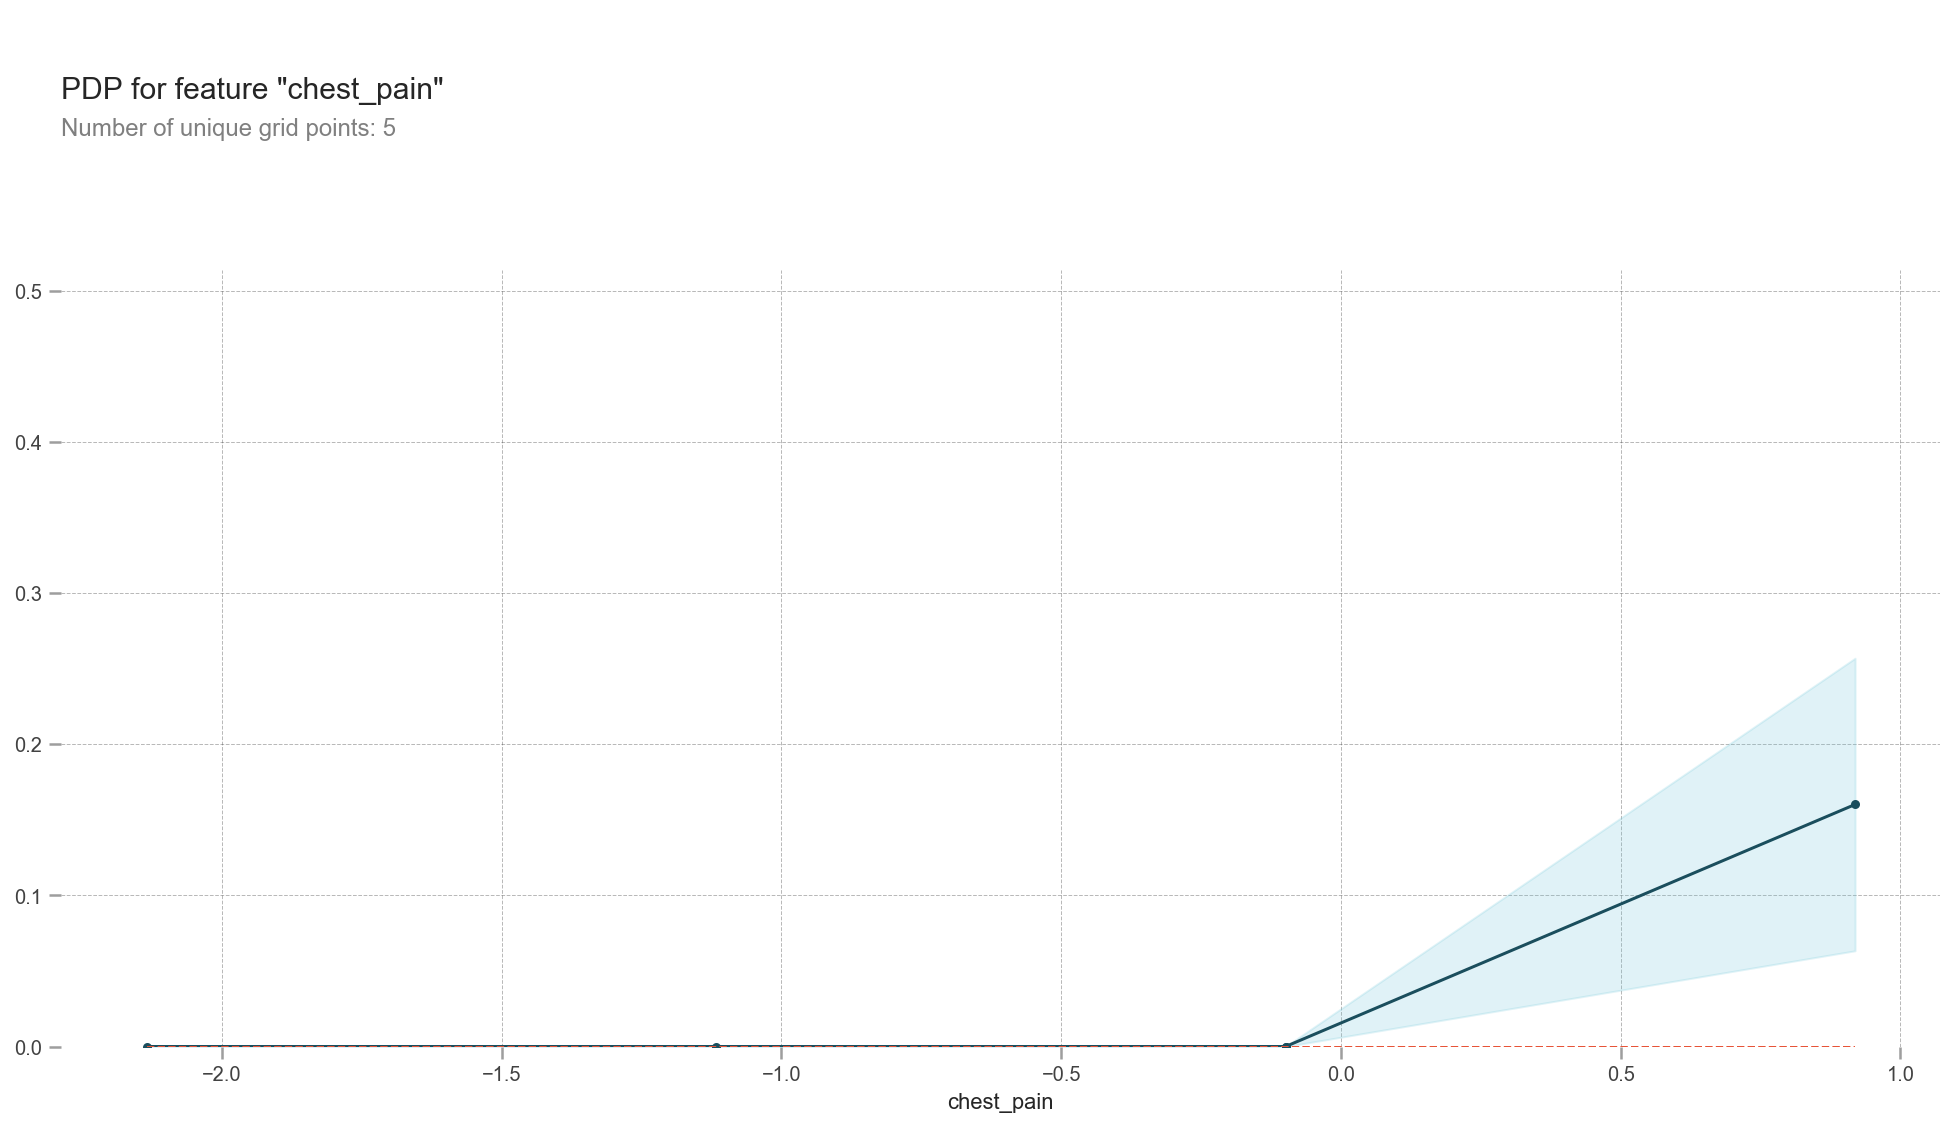

In [59]:
feat_name = 'chest_pain'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

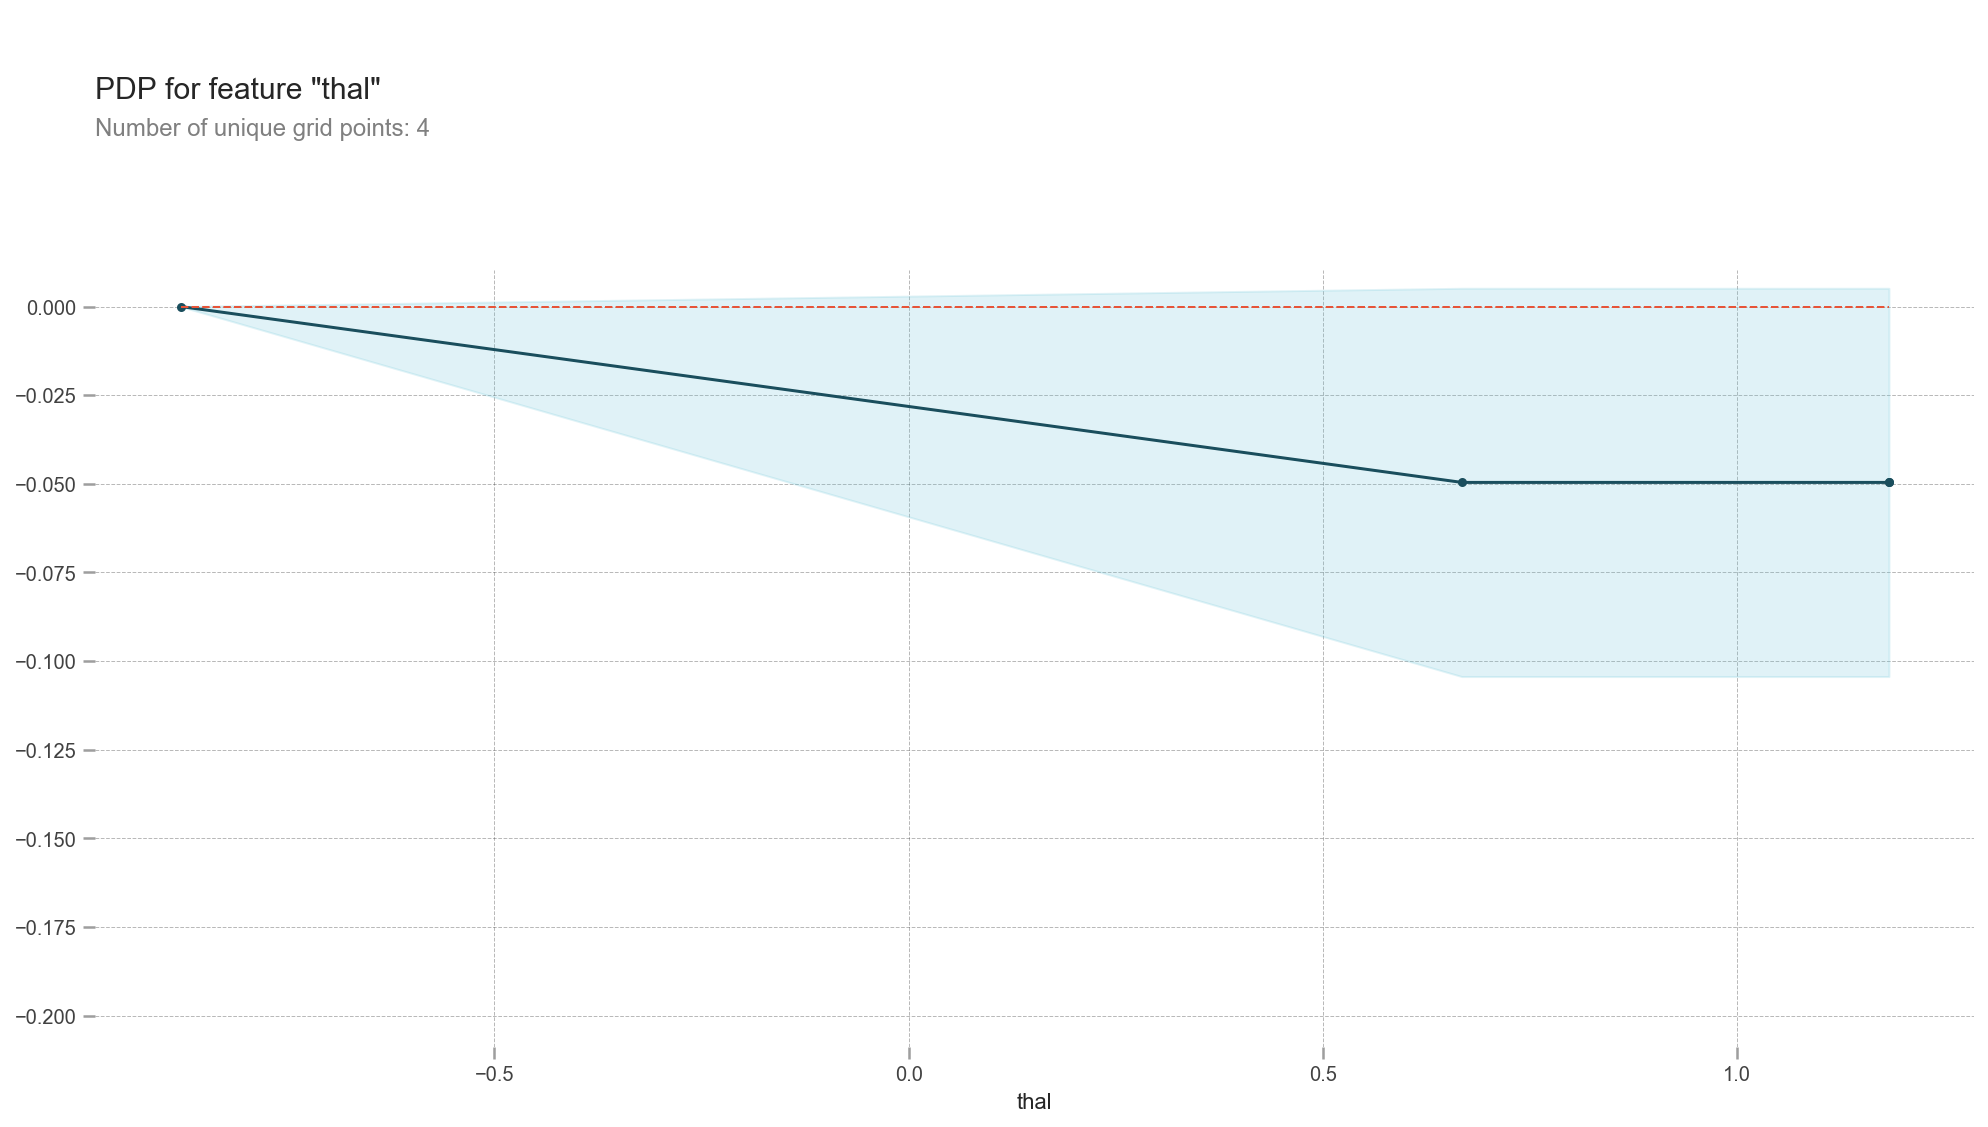

In [60]:
feat_name = 'thal'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()